### Option 3: Maintenance cost reduction through predictive techniques
BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.


GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict
is called failure with binary value 0 for non-failure and 1 for failure.


DATA
Download link: http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

In [2]:
#Basic libraries
import os
import re
import pandas as pd
import numpy as np
import datetime
import itertools

#Graphic libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

from mpl_toolkits.mplot3d import Axes3D

from functools import partial

#Quick EDA
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [3]:
data_df = pd.read_csv('../data/predictive_maintenance.csv', parse_dates=["date"])

In [4]:
pandas_profiling.ProfileReport(data_df.reset_index(), check_correlation=True)

Number of variables,13
Number of observations,124494
Total Missing (%),0.0%
Total size in memory,12.3 MiB
Average record size in memory,104.0 B
Numeric,9
Categorical,1
Boolean,1
Date,1
Text (Unique),0
Rejected,1


## Feature Engineering

In [5]:
#Drop correlated features 
data_df = data_df.drop('metric7', axis=1)

In [6]:
#Extract day of week and month
data_df['dayofweek'] = data_df.date.dt.dayofweek
data_df['month'] = data_df.date.dt.month

In [7]:
#numerics metrics
metrics_num = data_df.columns.difference(['date','id','failure','month', 'dayofweek'])

## Distribution plots

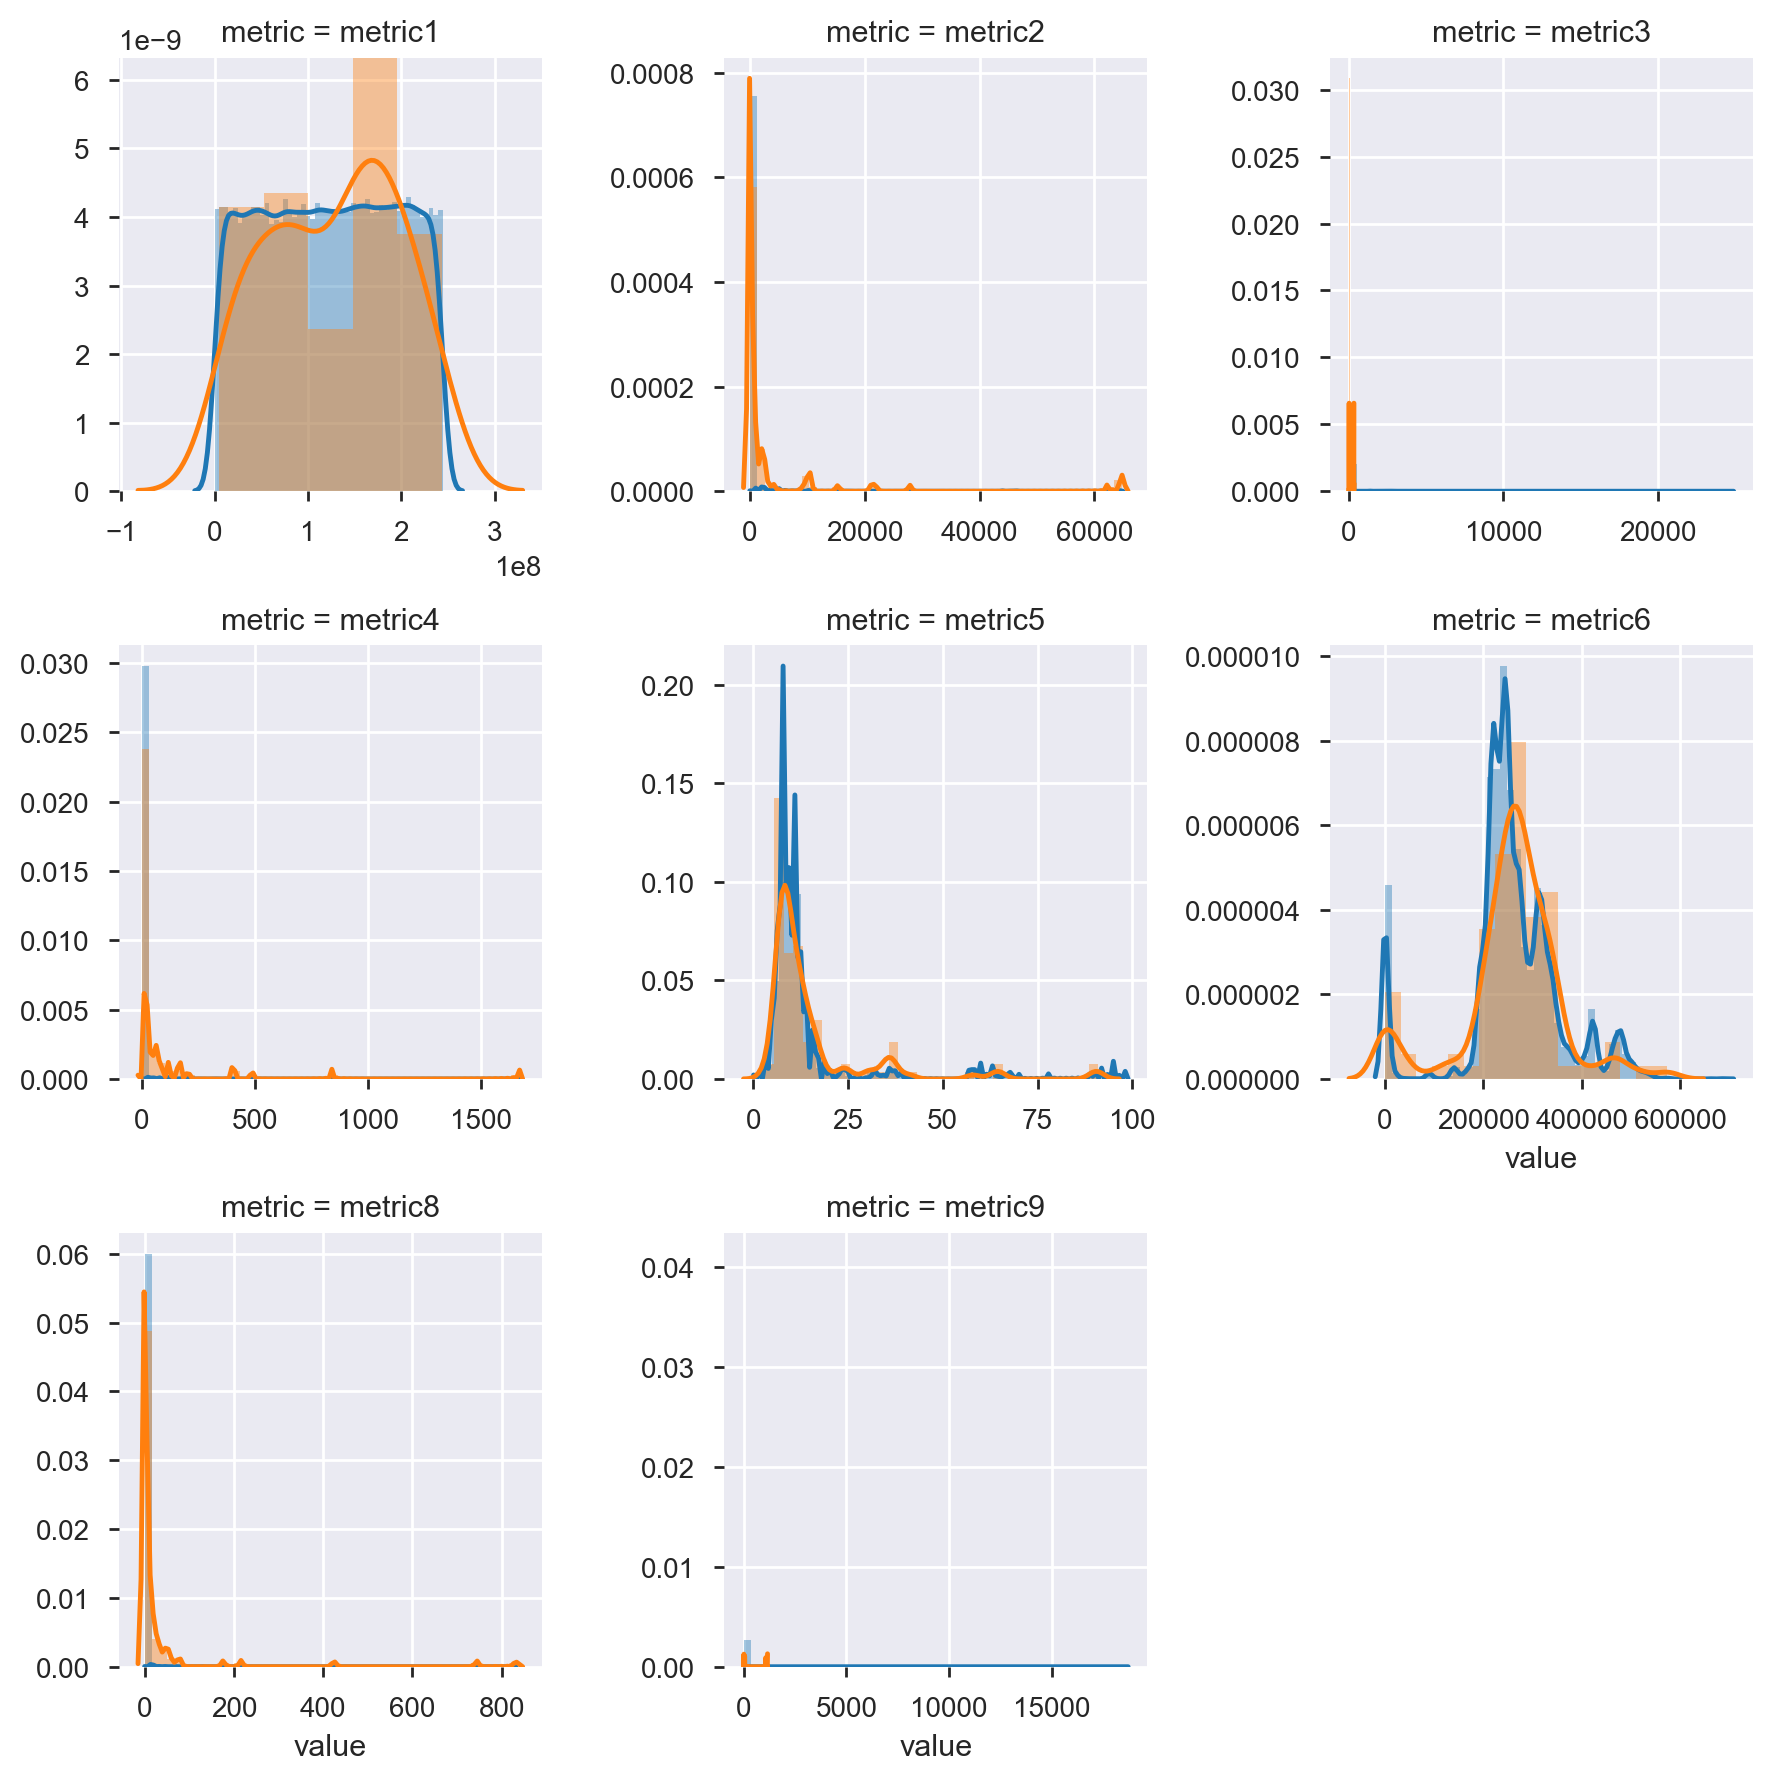

In [8]:
_ = data_df.melt(id_vars=['failure'], value_vars=metrics_num, var_name='metric')
g = sns.FacetGrid(data=_, col = "metric", hue='failure', sharey=False, sharex=False, col_wrap=3)
g.map(sns.distplot, 'value')
plt.show()

### Box plot

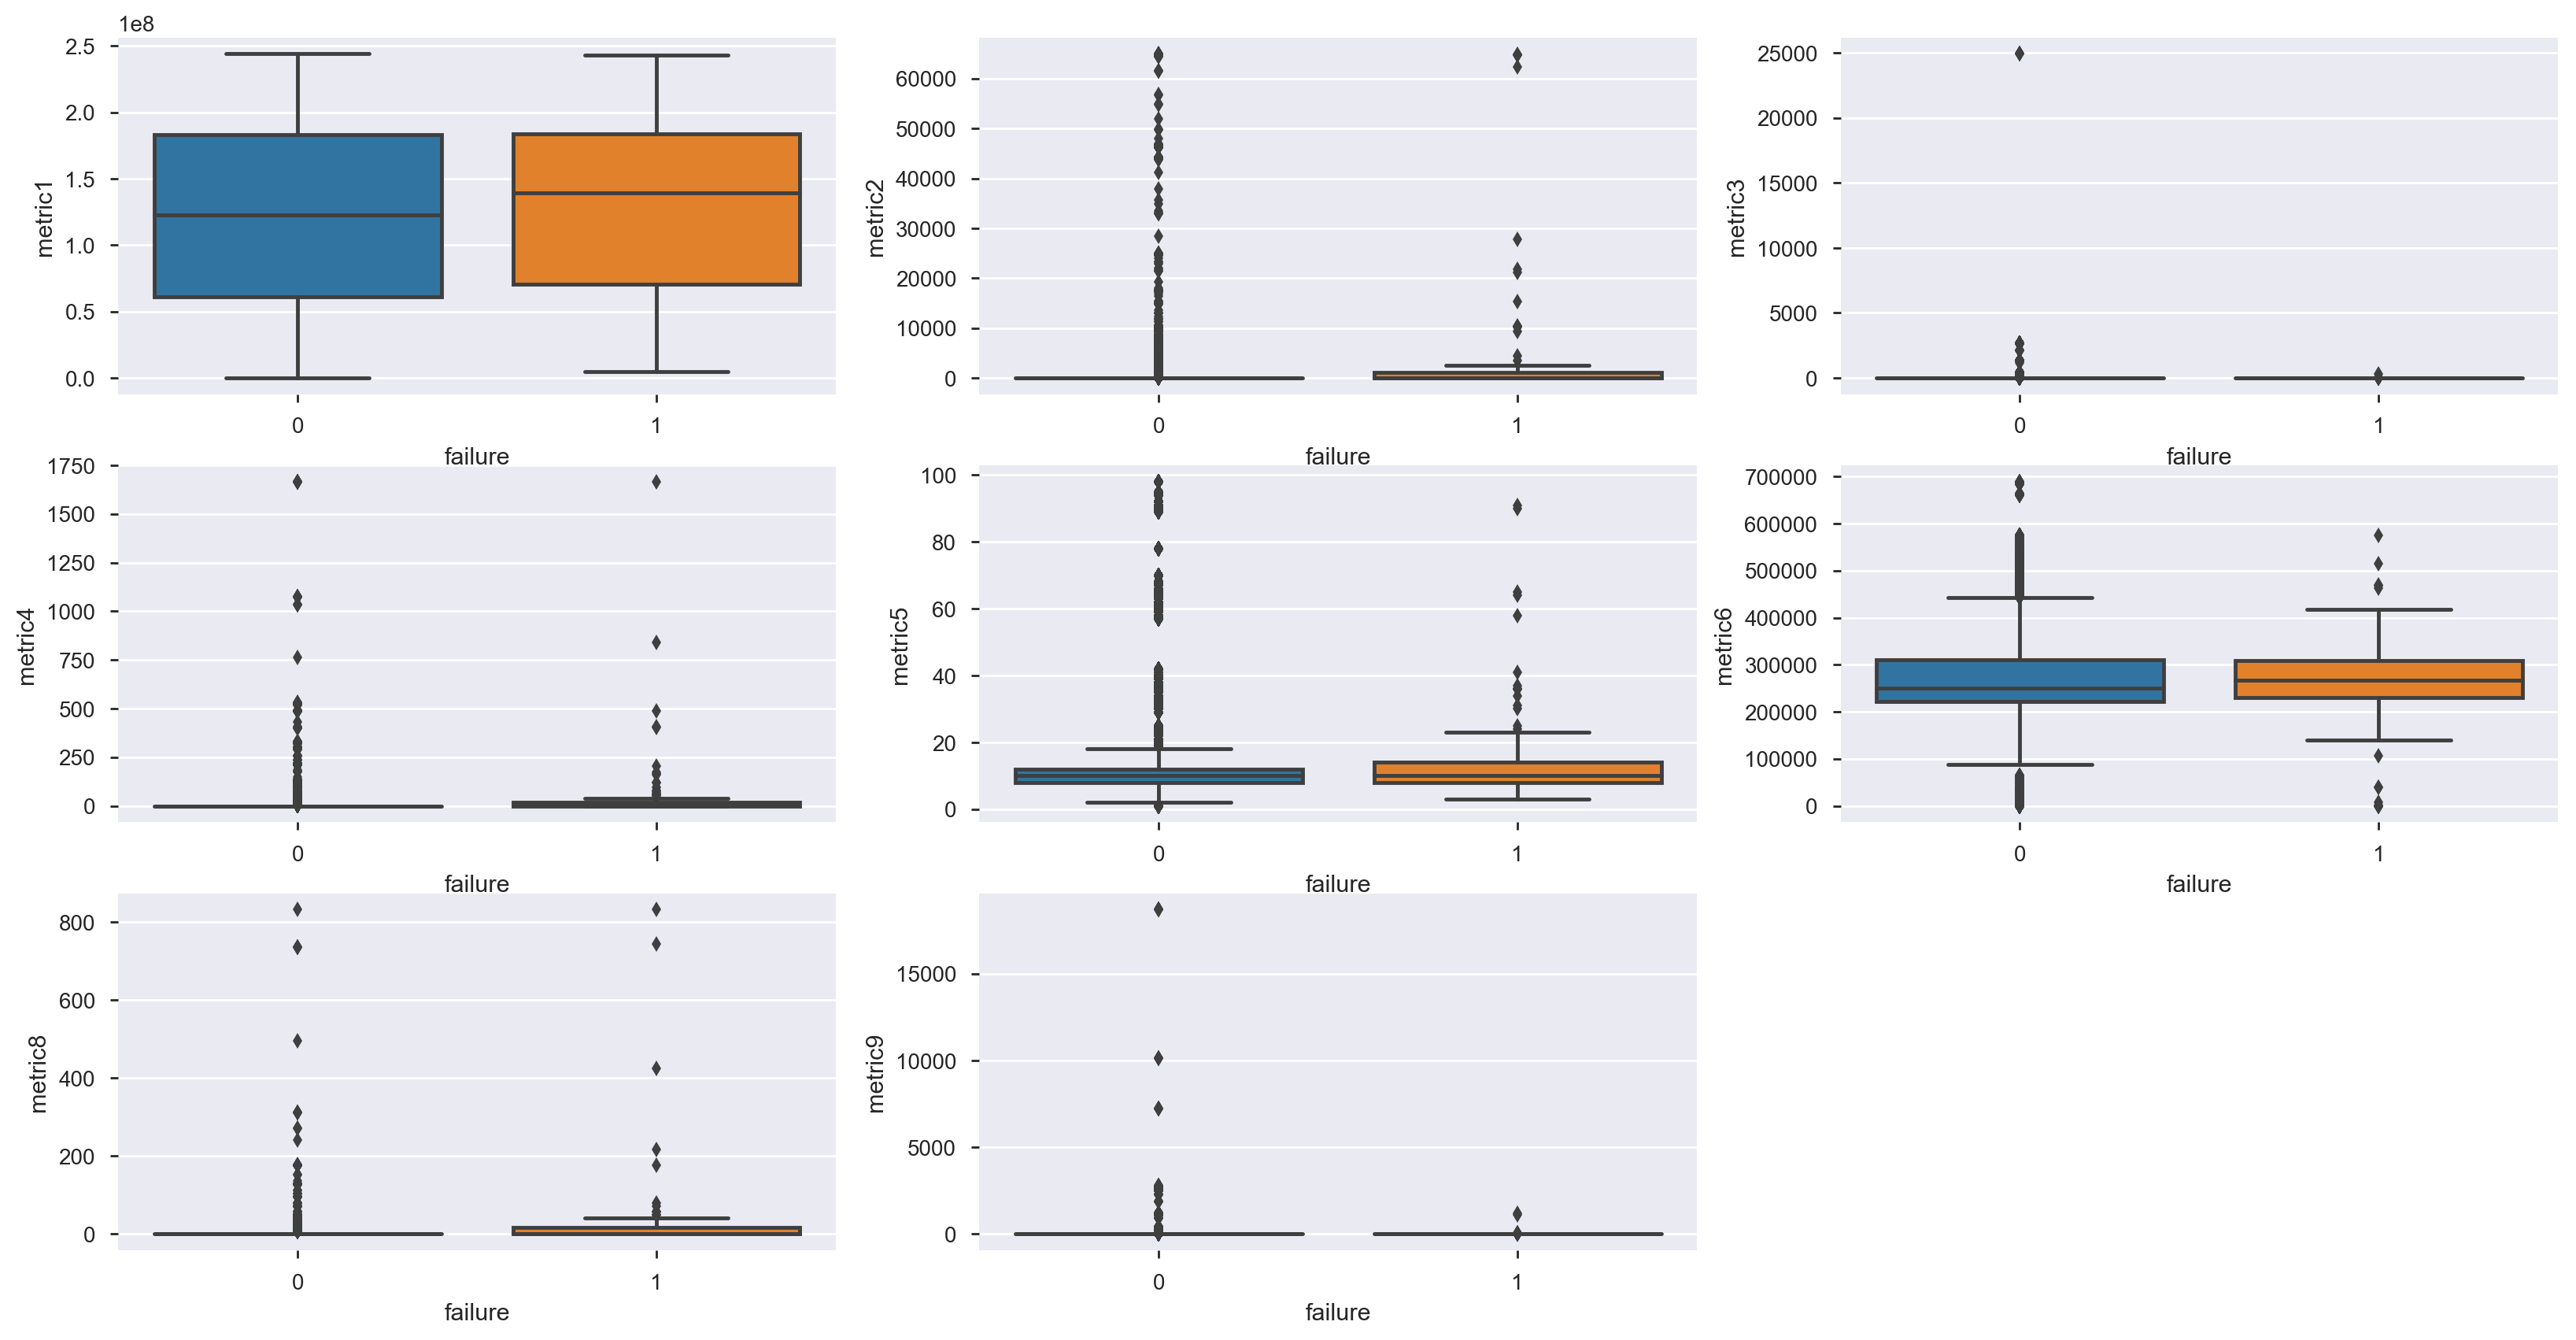

In [9]:
plt.figure(figsize=(20,10))
for i, c in enumerate(metrics_num):
    plt.subplot(3,3, i+1)
    sns.boxplot(x='failure', y=c, data=data_df)
plt.show()

### Date-Time relationship


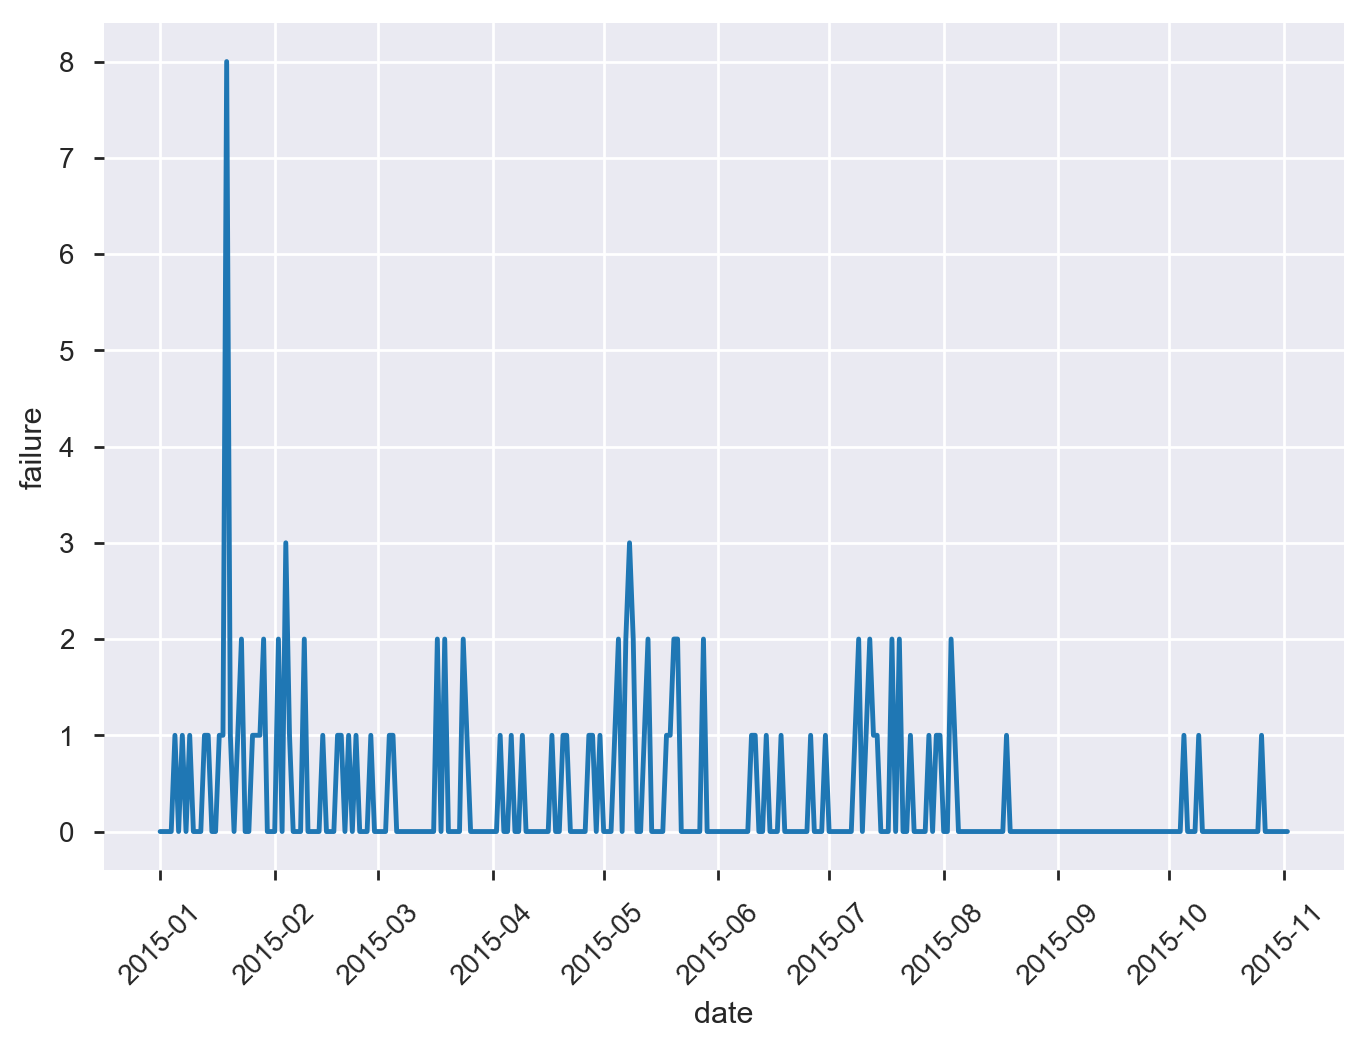

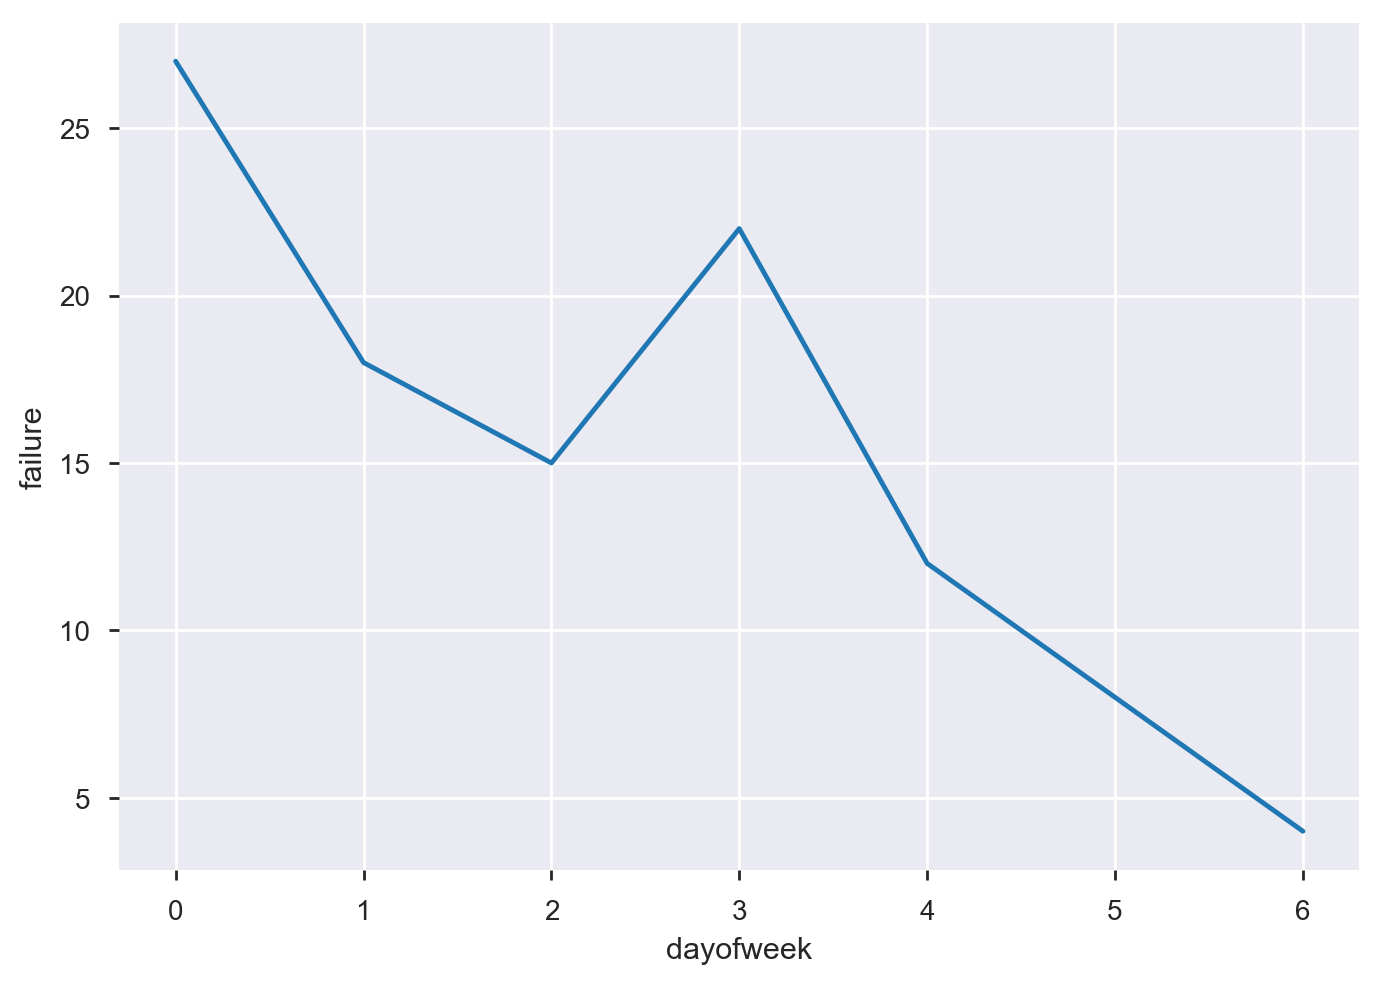

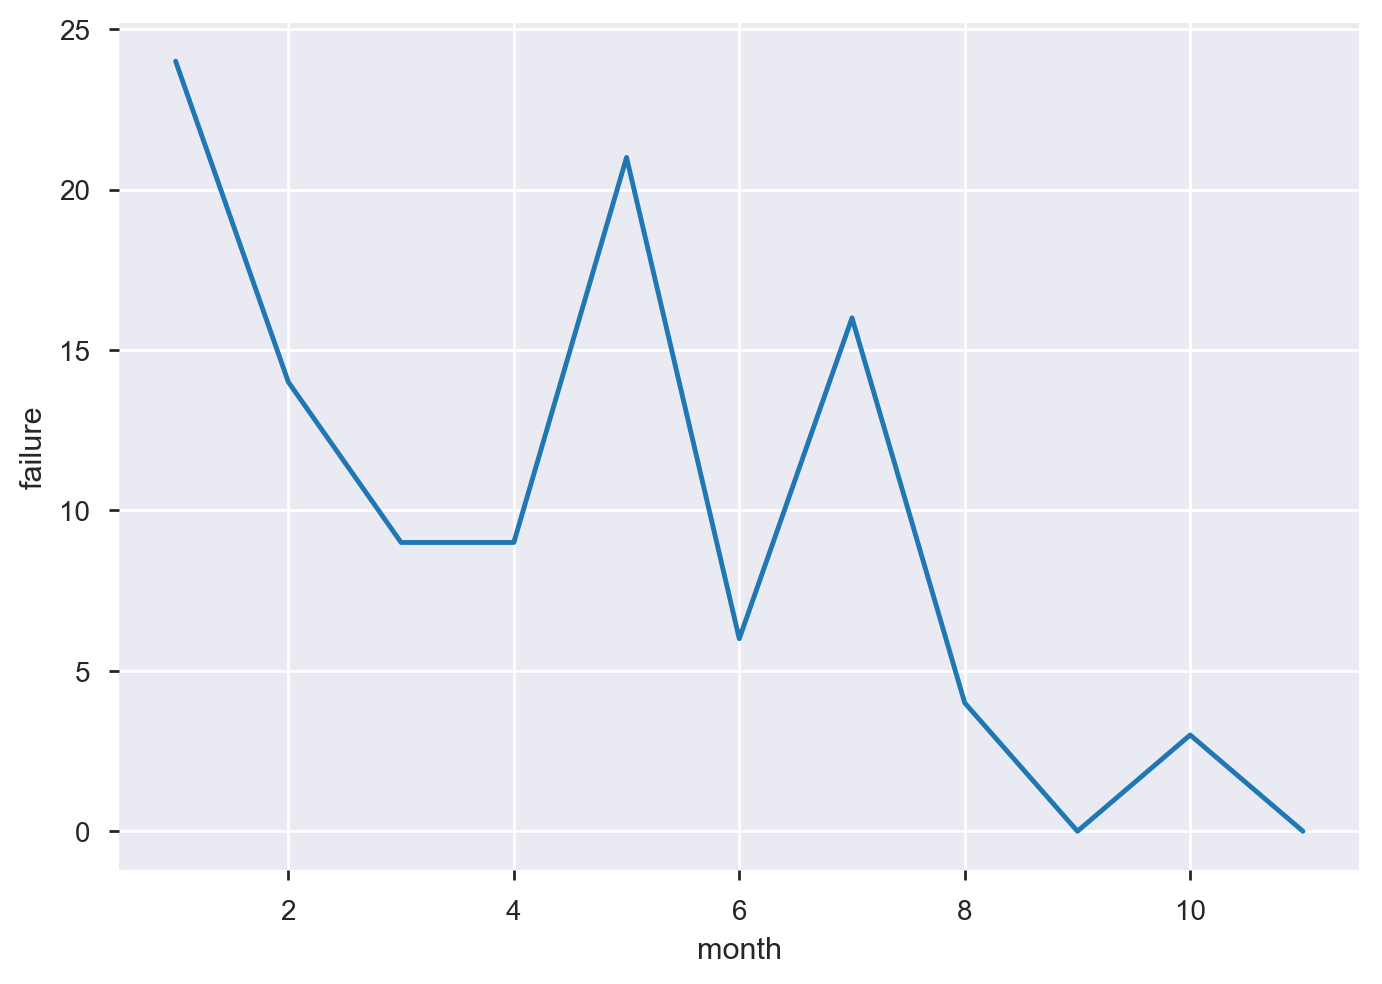

In [10]:
_ = data_df.groupby('date')['failure'].sum().reset_index()
ax = sns.lineplot(x='date', y='failure', data=_)
plt.xticks(rotation=45)
plt.show()

_ = data_df.groupby('dayofweek')['failure'].sum().reset_index()
sns.lineplot(x='dayofweek', y='failure', data=_)
plt.show()

_ = data_df.groupby('month')['failure'].sum().reset_index()
_ = _.sort_values(by=['month'])
sns.lineplot(x='month', y='failure', data=_)
plt.show()

We can see most of the faults are in the begining of the period and at the begining of the week, then the number start to decline towards the end.  

In [11]:
_1 = data_df[data_df.failure == 1]
_0 = data_df[data_df.failure == 0]
print('No of unique devices: {}'.format(len(data_df.id.unique())))
print('No of devices reported faults: {}'.format(len(_1.id.unique())))

No of unique devices: 1169
No of devices reported faults: 106


In [12]:
#Dropping date axis
data_df.drop('date', axis=1, inplace=True)

## Data splitting

In [13]:
from sklearn.model_selection import train_test_split

X = data_df.drop('failure', axis = 1)
y = data_df['failure'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print('No of 1s in training {}'.format(len(X_train[y_train==1])))
print('No of 1s in testing {}'.format(len(X_test[y_test==1])))

No of 1s in training 79
No of 1s in testing 27


## Converting categorial features

To experiment the impact of id, day, month of the week, One-hot encoding is used for the day of the week, month, and target encoding for the ids 

In [14]:
import category_encoders as ce

hot_encoder = ce.OneHotEncoder(cols=['dayofweek', 'month'])
target_encoder = ce.TargetEncoder(cols=['id'])

X_train = hot_encoder.fit_transform(X_train)
X_train = target_encoder.fit_transform(X=X_train, y=y_train)

X_test  = hot_encoder.transform(X_test)
X_test = target_encoder.transform(X=X_test)

In [15]:
##categorial only features
metrics_cat = X_train.columns.difference(metrics_num)

In [16]:
X_train.head()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
66747,0.000000,89139888,0,0,0,9,244813,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
111196,0.004505,232140000,0,0,0,8,301096,8,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
54161,0.000000,232465688,0,0,0,14,338421,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
116492,0.000000,173578248,0,0,0,8,319194,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
106501,0.000000,106330016,0,0,0,16,364710,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [17]:
X_test.head()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
26226,0.0,169304416,0,0,0,9,372747,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
111996,0.0,88970840,0,0,0,5,225378,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
67630,0.0,34224320,0,2,0,94,241355,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
124092,0.0,145224088,0,0,0,8,360299,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
99383,0.0,134602096,0,0,0,59,248496,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Data standarisation for LinearRegression

In [18]:
##Scalling data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[metrics_num] = scaler.fit_transform(X_train_scaled[metrics_num])
X_test_scaled[metrics_num] = scaler.transform(X_test_scaled[metrics_num])

## Oversampling
Due to imbalanced classes, the minority class is oversampled using different techniques.

In [230]:
%%time
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SMOTENC

class Sampler(object):
    sampler = {'SMOTE':SMOTE(random_state=42), 
               'ADASYN':ADASYN(random_state=42),
               'SMOTENC':SMOTENC(random_state=42, 
                                 categorical_features=[X_train.columns.get_loc(c) for c in metrics_cat]),
               'RandomOverSampler':RandomOverSampler(random_state=42)}
    def __init__(self, name):
        self.smplr = self.sampler[name]
    
    def sampling(self, X_train, y_train):
        X_sampled, y_sampled = self.smplr.fit_resample(X_train, y_train)
        X_sampled = pd.DataFrame.from_records(X_sampled, columns=X_train.columns)
        y_sampled = pd.Series(y_sampled, name='failure')
        return X_sampled, y_sampled

#Sampling using different methods

#ADASYN uses a weighted distribution for different minority class examples according 
#to their level of difficulty in learning, where more synthetic data is generated
#for minority class examples that are harder to learn.
sampler = Sampler('ADASYN')
X_train_ADASYN, y_train_ADASYN = sampler.sampling(X_train[metrics_num], y_train)
X_train_scaled_ADASYN, y_train_scaled_ADASYN = sampler.sampling(X_train_scaled[metrics_num], y_train)
X_test_ADASYN, y_test_ADASYN = sampler.sampling(X_test[metrics_num], y_test)

#SMOTENC takes the categorial data into consideration when oversampling
sampler = Sampler('SMOTENC')
X_train_sampled_SMOTENC, y_train_sampled_SMOTENC = sampler.sampling(X_train, y_train)
X_test_sampled_SMOTENC, y_test_sampled_SMOTENC = sampler.sampling(X_test, y_test)


CPU times: user 4min 18s, sys: 2.8 s, total: 4min 21s
Wall time: 4min 22s


## Classifier class definition

The class works as a wraper for different algorithms

In [112]:
#### Classifiers class
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, mean_absolute_error,accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


class Classifier(object):
    
    
    classifier = {'LogisticRegression':LogisticRegression(),
                  'XGBoost':xgb.XGBClassifier(),
                  'SVM': svm.SVC(),
                  'RandomForestClassifier': RandomForestClassifier()}
    
    
    #Classifier initial parameters
    clfr_init_param = {'LogisticRegression':{'random_state':42, 
                                             
                                             'max_iter':5
                                             }, 
                       'XGBoost': {'objective':'binary:logistic', 
                                   'max_delta_step': 1, 
                                   'random_state':42, 
                                   'min_child_weight':1},
                       'SVM': {'kernel': 'rbf', 
                               'class_weight':'balanced', 
                               'random_state':42},
                       'RandomForestClassifier': {'random_state':42}
                      }
    
    #Classifier tunning parameters
    clfr_tune_param = {'LogisticRegression':{'C':[0.005, 0.01, 0.1, 1.], 
                                             'penalty':['l1', 'l2'],
                                             'class_weight':[{1:10,0:1},{1:1,0:1}, 'balanced']
                                            },

                       'SVM': {'C':[0.005, 0.01, 0.1], 
                               'gamma':[0.001, 0.01, 0.1, 1]},
                       
                       'RandomForestClassifier': {'bootstrap': [True, False],
                                                  'max_depth': [10, 20, 30],
                                                  'max_features': ['auto', 'sqrt'],
                                                  'min_samples_leaf': [1, 2, 4],
                                                  'min_samples_split': [2, 5, 10],
                                                  'n_estimators': [200, 600, 800, 1000, 1200]},
                        'XGBoost':{
                                    'learning_rate': (0.001, 0.01, 'log-uniform'),
                                    'max_depth': (2, 6),
                                    'subsample': (0.1, 1.0, 'uniform'),
                                    'colsample_bytree': (0.1, 1.0, 'uniform'),
                                    'n_estimators': (400, 2000),
                                    'gamma': (0, 10., 'uniform')
                                    }
                      }
                           
    def __init__(self, name):
        self.name = name
        self.tune_param = {'clsfr__'+k: v for k,v in self.clfr_tune_param[name].items()}
        self.model = self.classifier[name].set_params(**self.clfr_init_param[name])   

In [227]:
#Plot class
class Plot:
    
    def __init__(self):
        pass
    
    @staticmethod  
    def plot_auc(y_test, y_pred_prob):
       
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr, marker='.')
        plt.show()
        auc_score = roc_auc_score(y_test, y_pred_prob)
        print('AUC: %.3f' % auc_score)
    
    @staticmethod
    def plot_precision_recall(y_test, y_pred_prob):
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob) 
        plt.title("Precision-Recall vs Threshold Chart")
        plt.plot(thresholds, precision[:-1], "b--", label="Precision")
        plt.plot(thresholds, recall[:-1], "r--", label="Recall")
        plt.ylabel("Precision, Recall")
        plt.xlabel("Threshold")
        plt.legend(loc="lower left")
        plt.ylim([0,1])
        plt.show()

        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve')
        plt.show()
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        
        print("Classification Report: \n", classification_report(y_true=y_true, y_pred=y_pred))
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
        print("\nAccuracy",accuracy)
        
        conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
        print('Confusion matrix:\n', conf_mat)

        labels = ['Class 0', 'Class 1']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()

In [225]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Cross validation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

class HyperTuning(object):
    
    def __init__(self):
        pass
    
    @staticmethod
    def grid_search(name, X_train, y_train):
        clfr = Classifier(name)
        pipe = Pipeline([('clsfr', clfr.model)])

        grid = GridSearchCV(pipe, cv=cv, 
                            param_grid=clfr.tune_param, 
                            iid=True, 
                            scoring='precision_weighted', 
                            verbose=3, 
                            n_jobs=-1,
                            refit=True
                           )

        grid.fit(X_train, y_train)
        
        print('Finished GridSearch')
        
        return grid 
    
    @staticmethod
    def baysian_search(name, X_train, y_train):
        clfr = Classifier(name)
        pipe = Pipeline([('clsfr', clfr.model)])

        opt = BayesSearchCV(
              estimator=pipe,
              scoring='f1_weighted',
              search_spaces = [(clfr.tune_param, 1)], # (parameter space, # of evaluations)
              cv=cv,
              verbose = True,
              n_jobs = -1,
              refit = True,
              random_state = 42
            )
        opt.fit(X_train, y_train)
        print('Finished Training')
        
        return opt
        
    
    @staticmethod
    def evaluate_opt(opt, X, y):
        print('Best model\n')
        print(opt.best_estimator_)
        print('\n')
        print('Best score on the validation: {}'.format(opt.best_score_))
        result_df = pd.DataFrame(opt.cv_results_)\
          .loc[:,['mean_test_score', 'rank_test_score', 'params']].sort_values(by='rank_test_score')
        print(result_df)
        print("*******************Training************************")
        print("Best. score: %s" % opt.best_score_)

        y_pred_prob = opt.predict_proba(X['train'])[:,1]
        y_pred = opt.predict(X['train'])
        Plot.confusion_matrix(y['train'], y_pred)

        ##################################
        print("*****************Testing***************************")

        y_pred_prob = opt.predict_proba(X['test'])[:,1]
        y_pred = opt.predict(X['test'])
        Plot.plot_auc(y_test, y_pred_prob)
        Plot.confusion_matrix(y['test'], y_pred)
        Plot.plot_precision_recall(y['test'], y_pred_prob)

## LinearRegression with SMOTENC Oversampling (All features)

It is clear that the model is overfitted on the training data. That is could be due to the 'id', day and month feature

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   18.1s finished


Finished GridSearch
Best model

Pipeline(memory=None,
     steps=[('clsfr', LogisticRegression(C=1.0, class_weight={1: 1, 0: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=5,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


Best score on the validation: 0.9888516651001933
*******************Training************************
Best. score: 0.9888516651001933
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     93291
           1       0.98      1.00      0.99     93291

   micro avg       0.99      0.99      0.99    186582
   macro avg       0.99      0.99      0.99    186582
weighted avg       0.99      0.99      0.99    186582


Accuracy 0.9886484226774287
Confusion matrix:
 [[91235  2056]
 [   62 93229]]


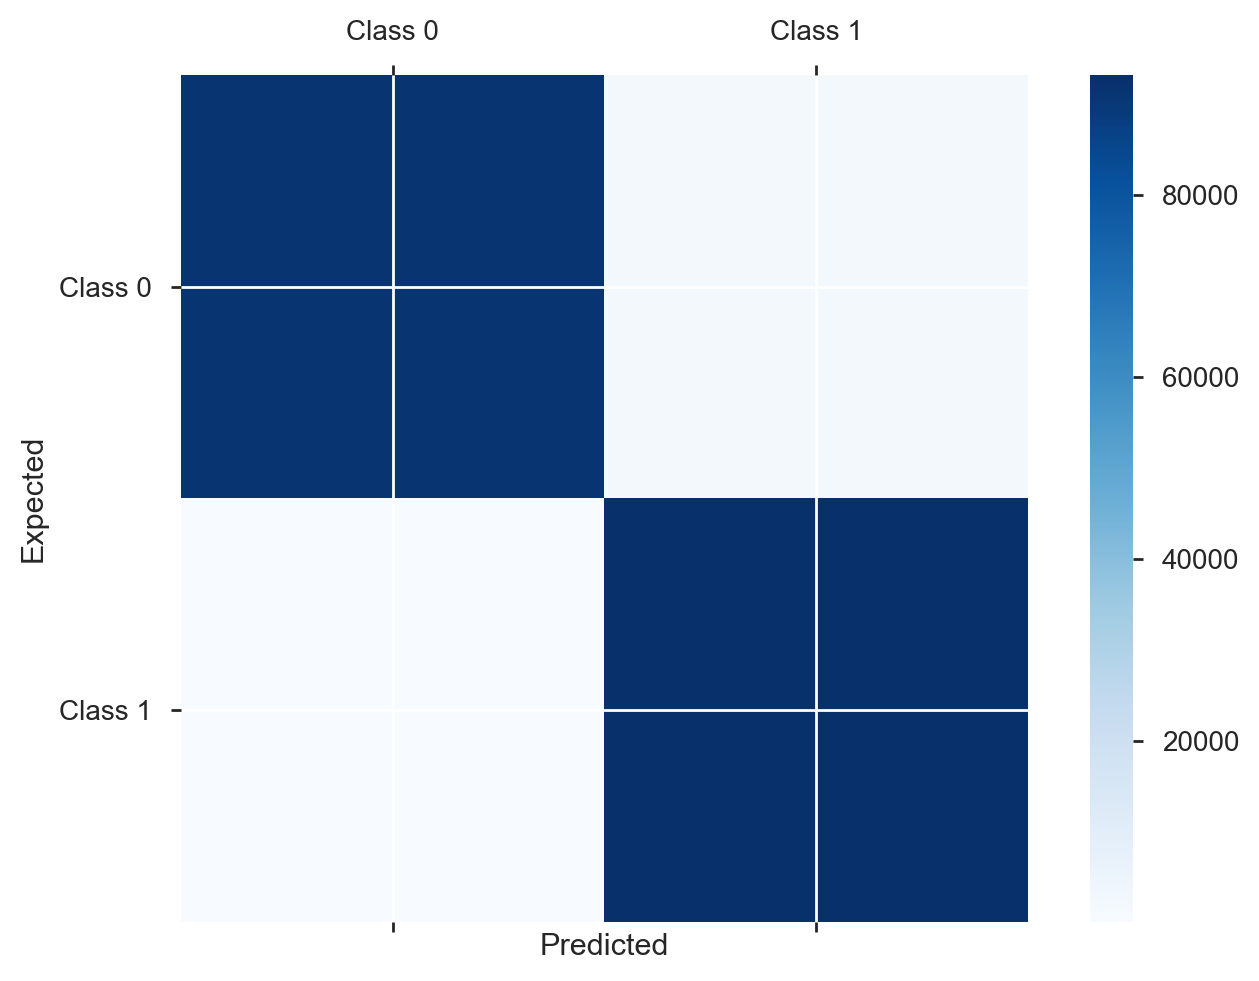

*****************Testing***************************


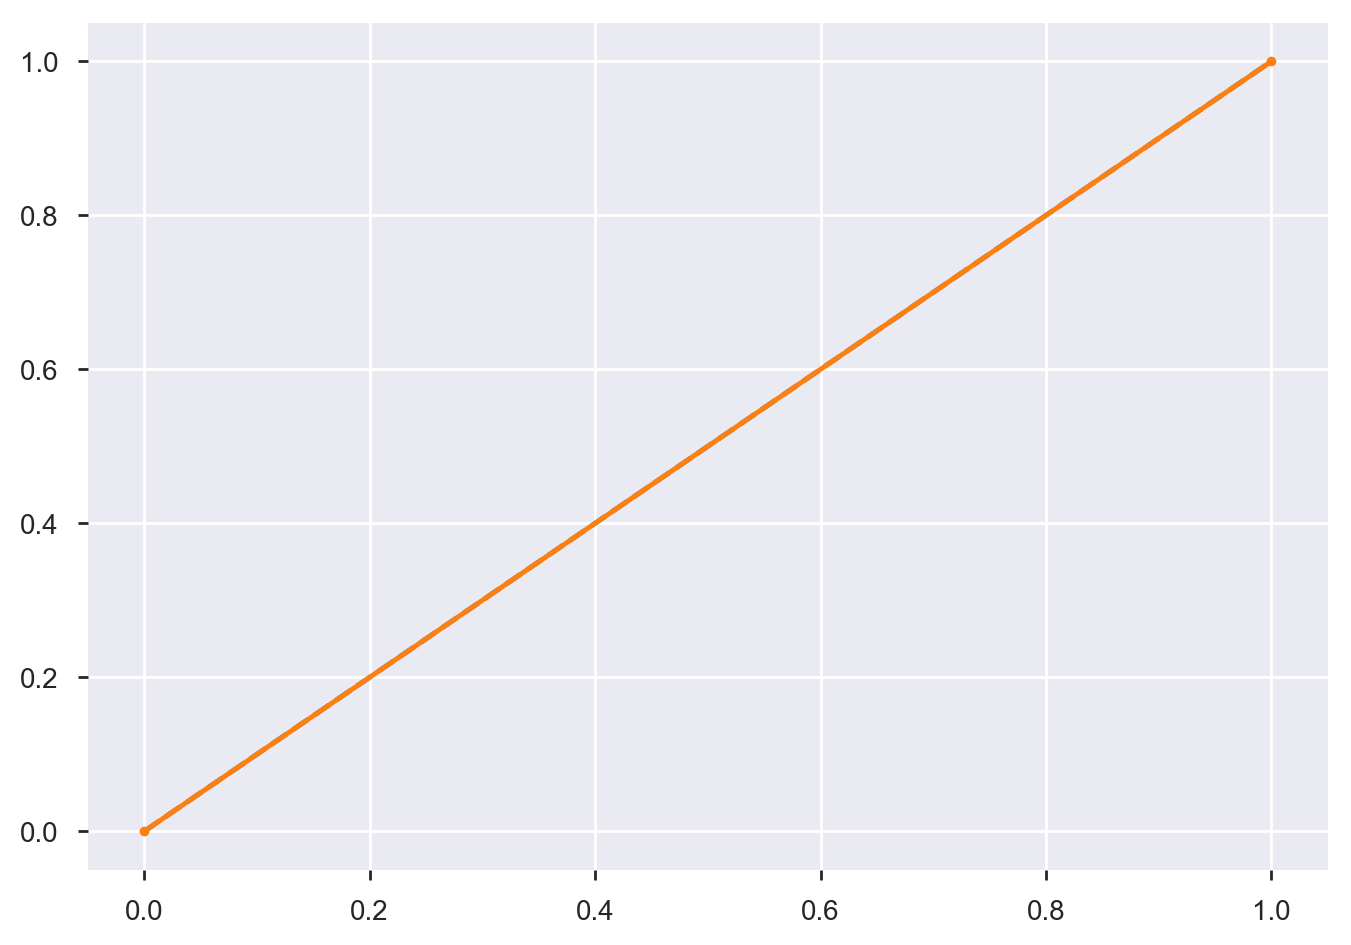

AUC: 0.500
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     31097
           1       0.00      1.00      0.00        27

   micro avg       0.00      0.00      0.00     31124
   macro avg       0.00      0.50      0.00     31124
weighted avg       0.00      0.00      0.00     31124


Accuracy 0.0008674977509317568
Confusion matrix:
 [[    0 31097]
 [    0    27]]


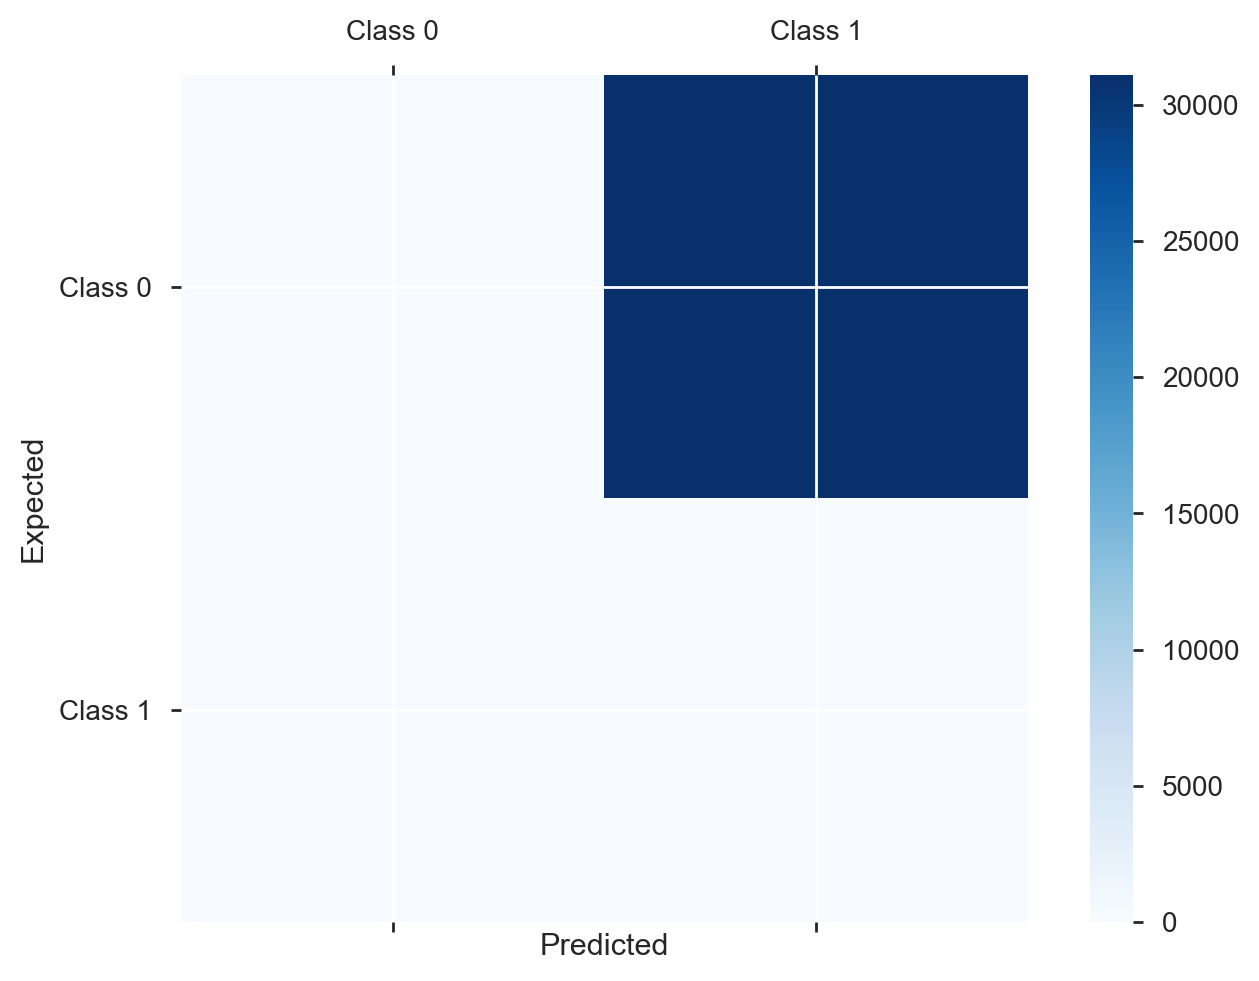

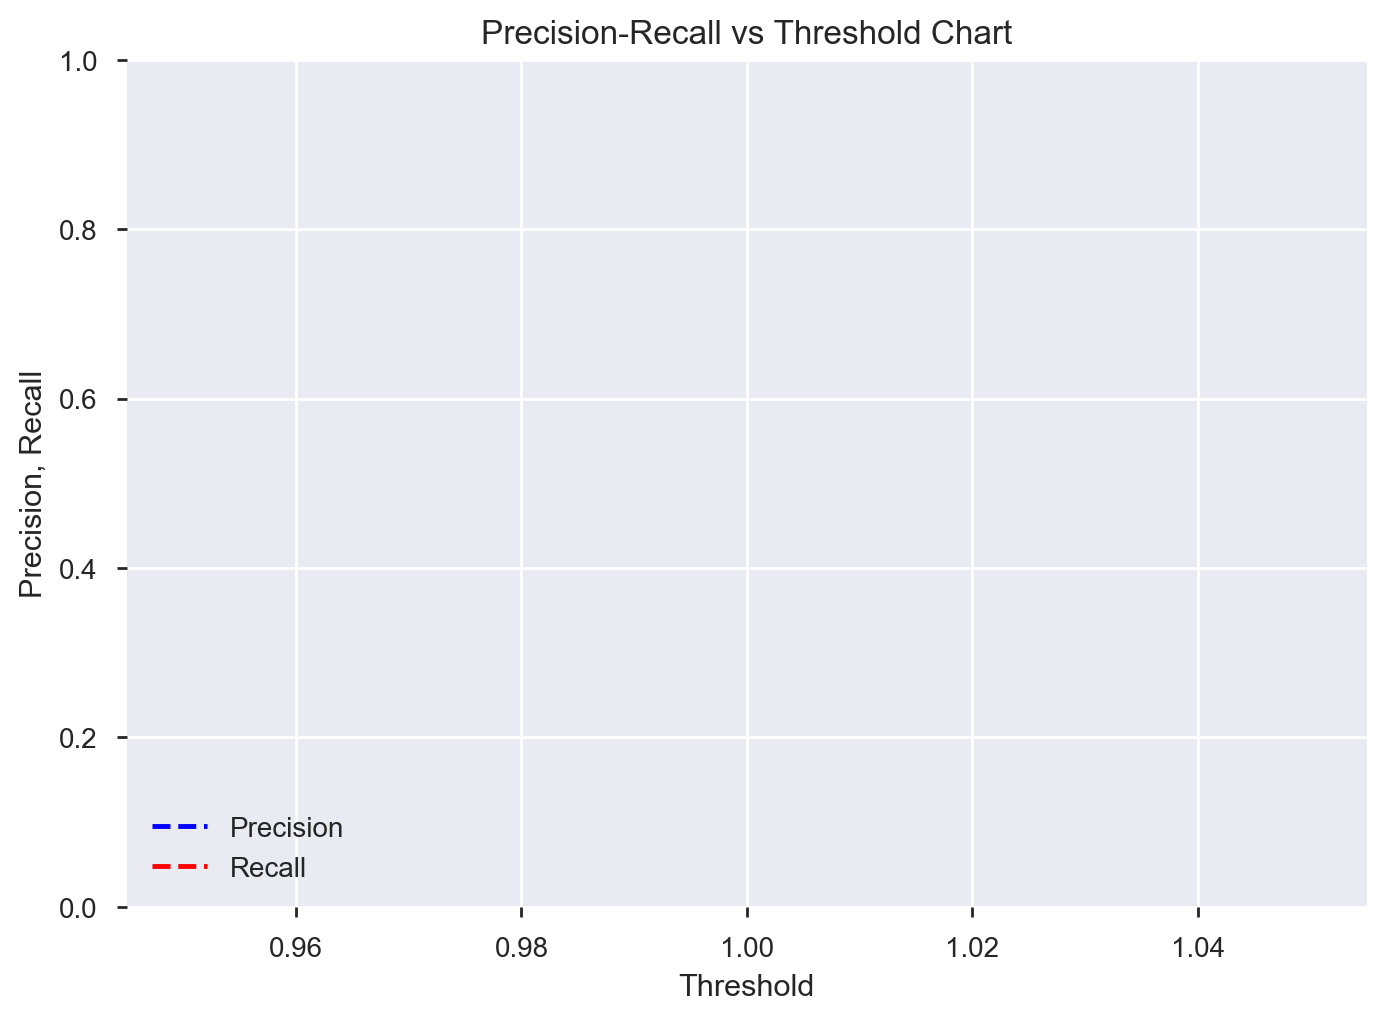

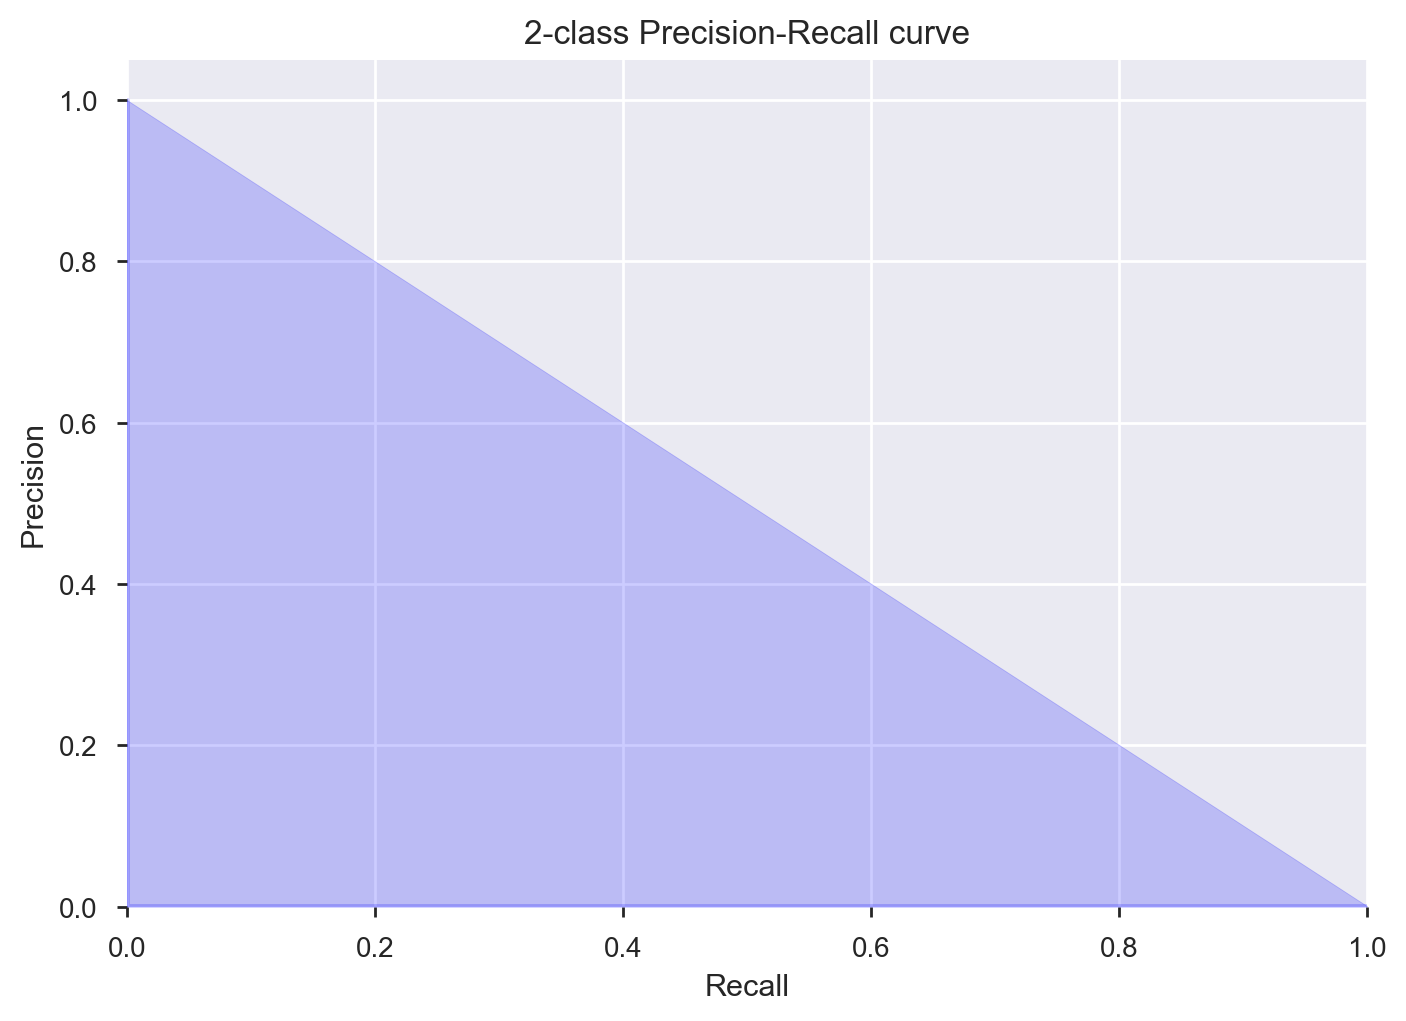

In [216]:
%time 
name = 'LogisticRegression'
X = {'train': X_train_scaled_SMOTENC, 'test':X_test}
y = {'train': y_train_scaled_SMOTENC, 'test':y_test}

grid = HyperTuning.grid_search(name, X_train_scaled_SMOTENC, 
                                     y_train_scaled_SMOTENC)
HyperTuning.evaluate_opt(grid, X, y)

## XGBoost with ADASYN Oversampling

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Finished Training
Best model

Pipeline(memory=None,
     steps=[('clsfr', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.46909356296798244, gamma=7.277257431773251,
       learning_rate=0.008567773934012713, max_delta_step=1, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1472, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4727067692369846))])


Best score on the validation: 0.9603353826124963
*******************Training************************
Best. score: 0.9603353826124963
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     93291
           1       0.96      0.96      0.96     93299

   micro avg       0.96      0.96      0.96    186590
   macro avg       0.96      0.96      0.96    186590
weighted avg       0.96   

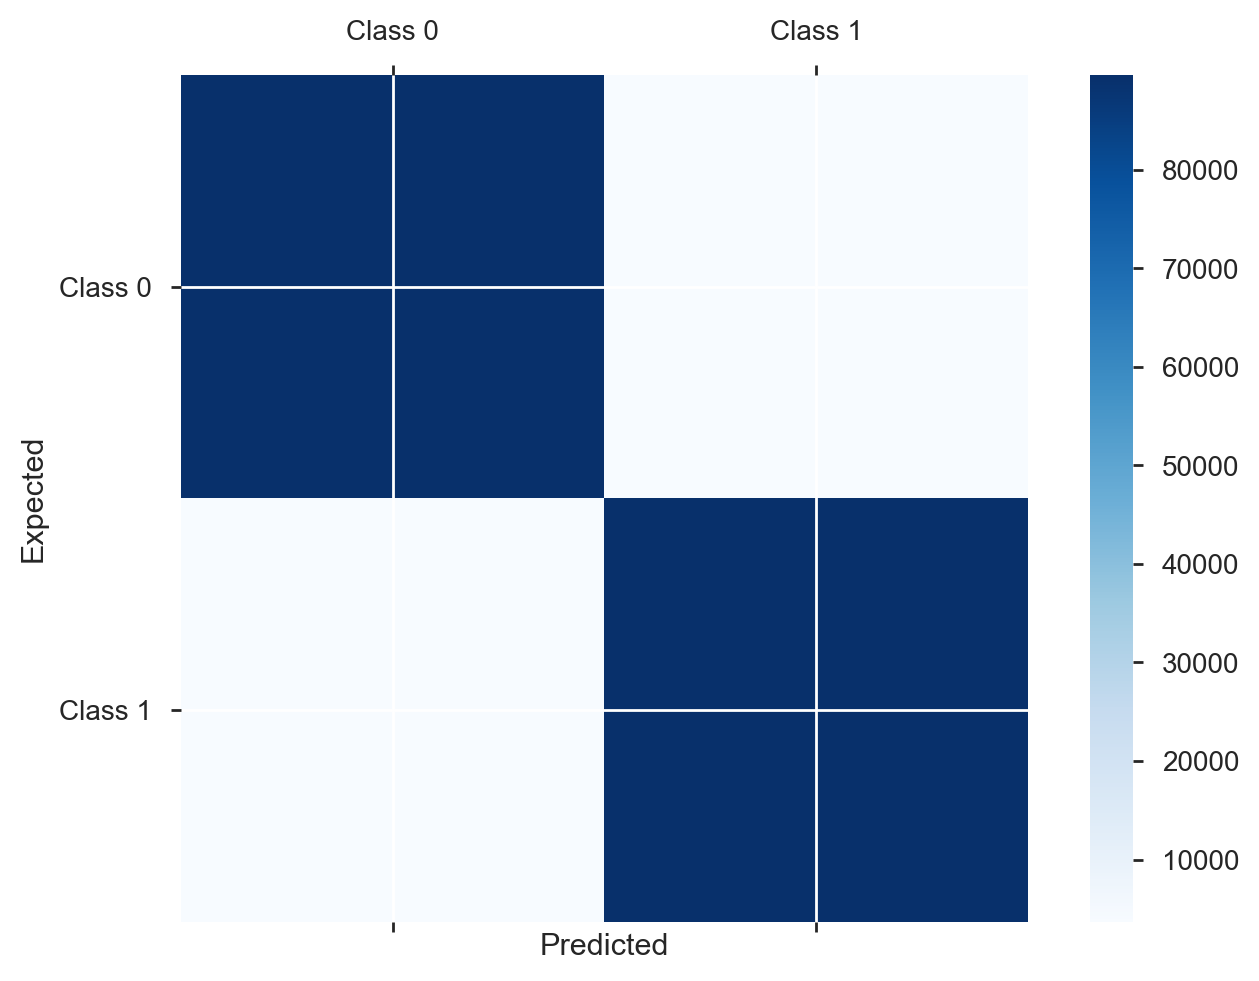

*****************Testing***************************


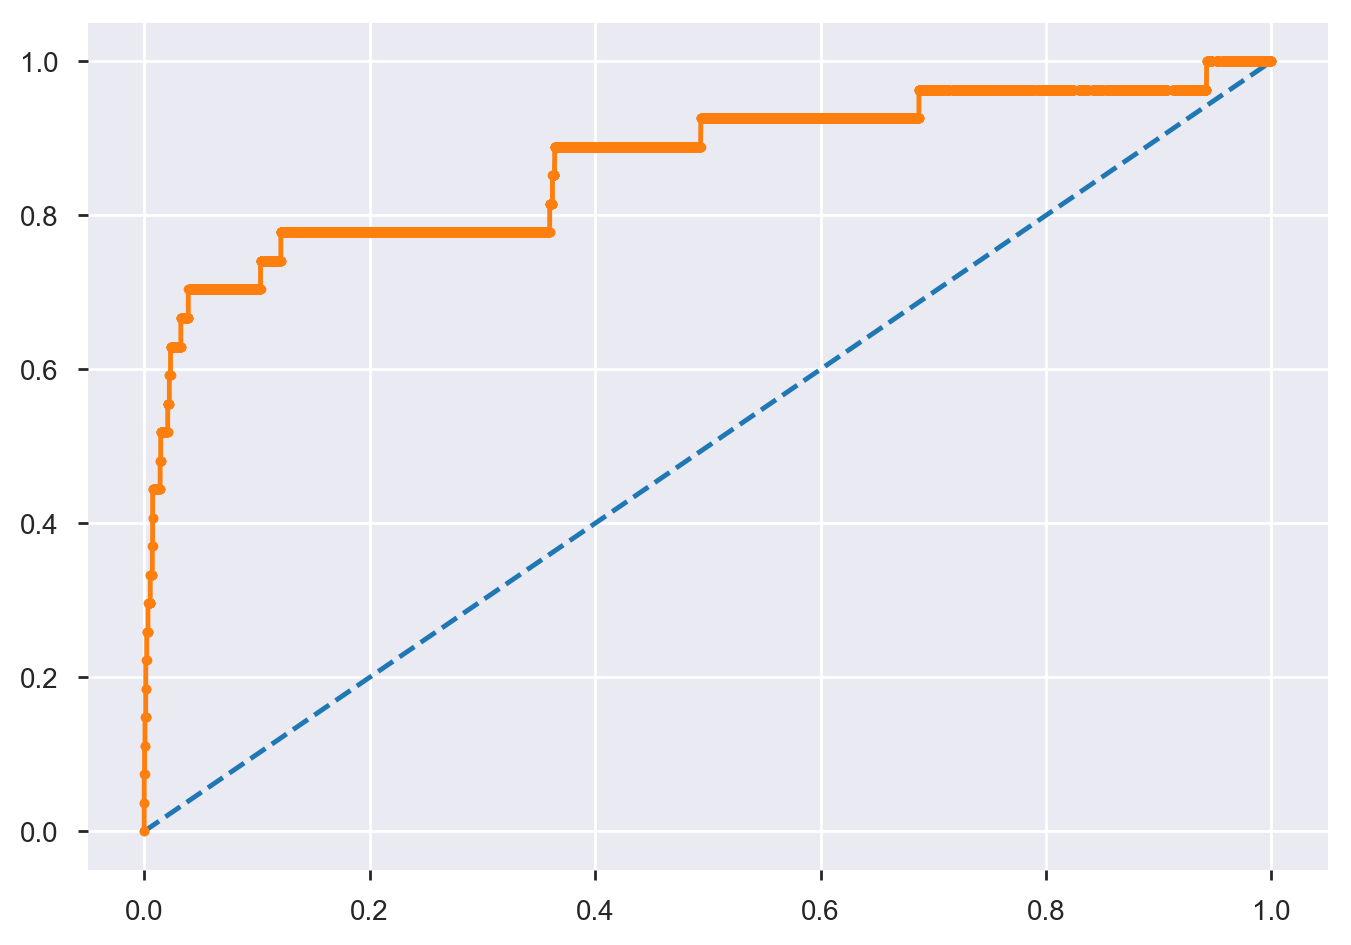

AUC: 0.865
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     31097
           1       0.02      0.67      0.03        27

   micro avg       0.96      0.96      0.96     31124
   macro avg       0.51      0.81      0.51     31124
weighted avg       1.00      0.96      0.98     31124


Accuracy 0.9619264875979952
Confusion matrix:
 [[29921  1176]
 [    9    18]]


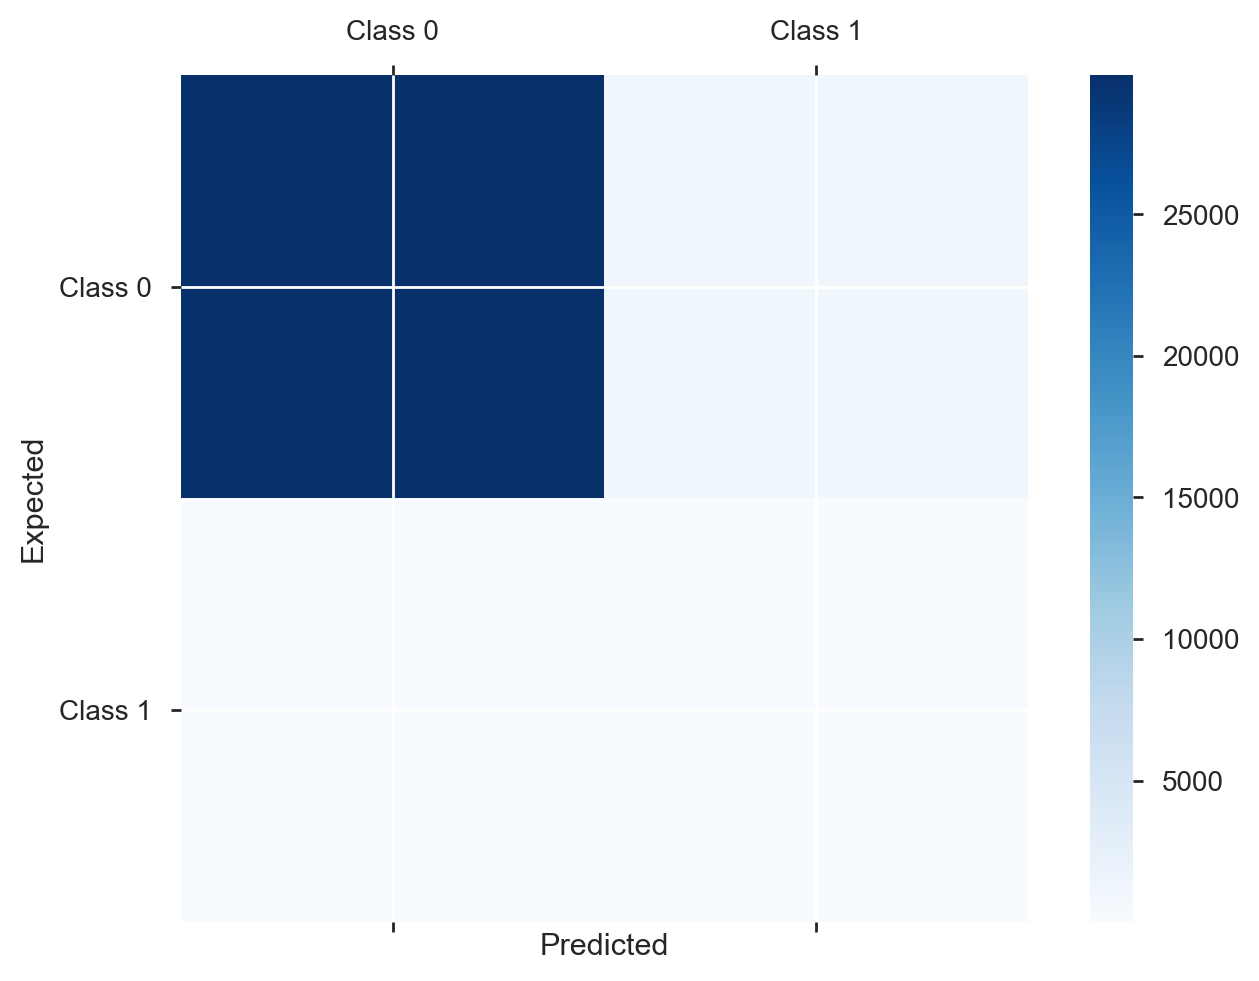

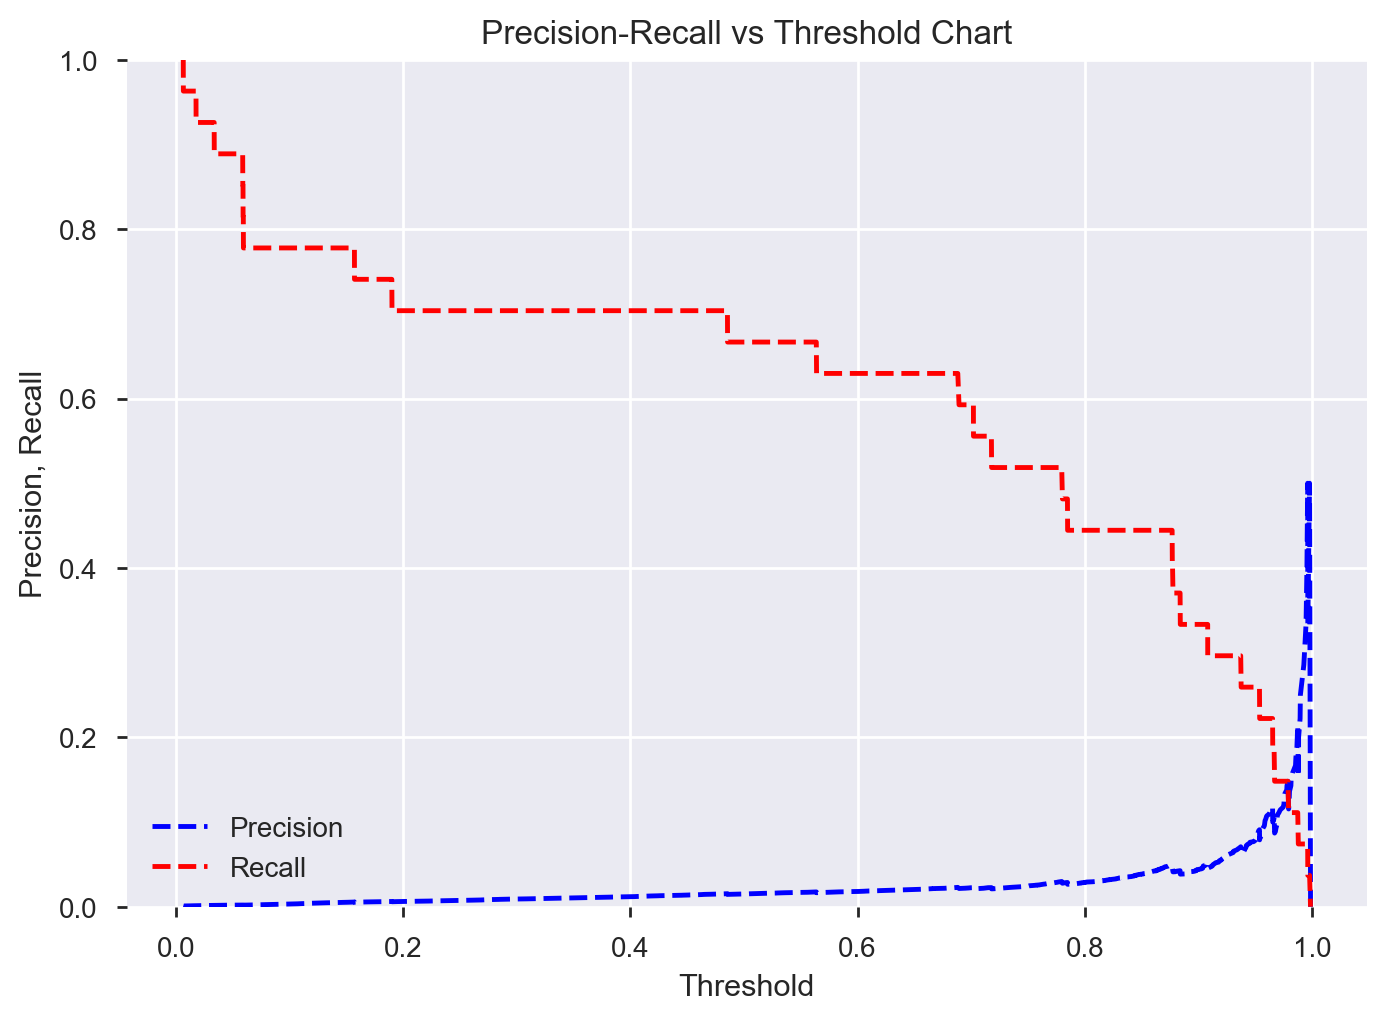

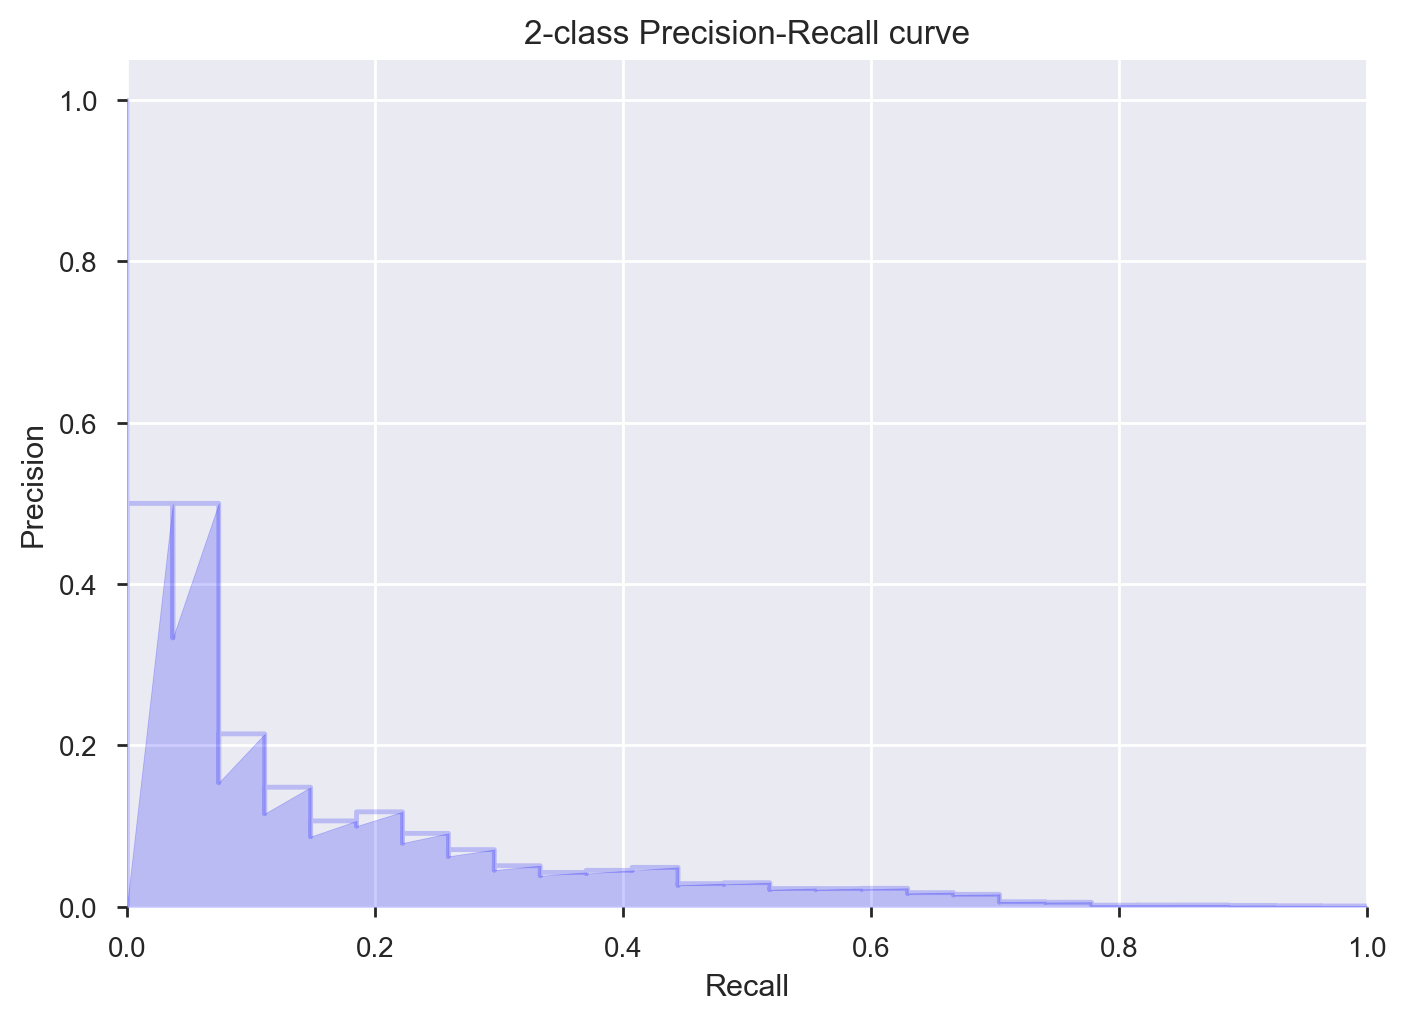

In [228]:
%time 
name = 'XGBoost'
features = X_train_ADASYN.columns
X = {'train': X_train_ADASYN.as_matrix(), 'test':X_test[features].as_matrix()}
y = {'train': y_train_ADASYN.as_matrix(), 'test':y_test.as_matrix()}

opt = HyperTuning.baysian_search(name, X['train'], y['train'])
HyperTuning.evaluate_opt(opt, X, y)

### Calibiration of probabilities

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     31097
           1       0.02      0.70      0.03        27

   micro avg       0.96      0.96      0.96     31124
   macro avg       0.51      0.83      0.50     31124
weighted avg       1.00      0.96      0.98     31124


Accuracy 0.9598380670864928
Confusion matrix:
 [[29855  1242]
 [    8    19]]


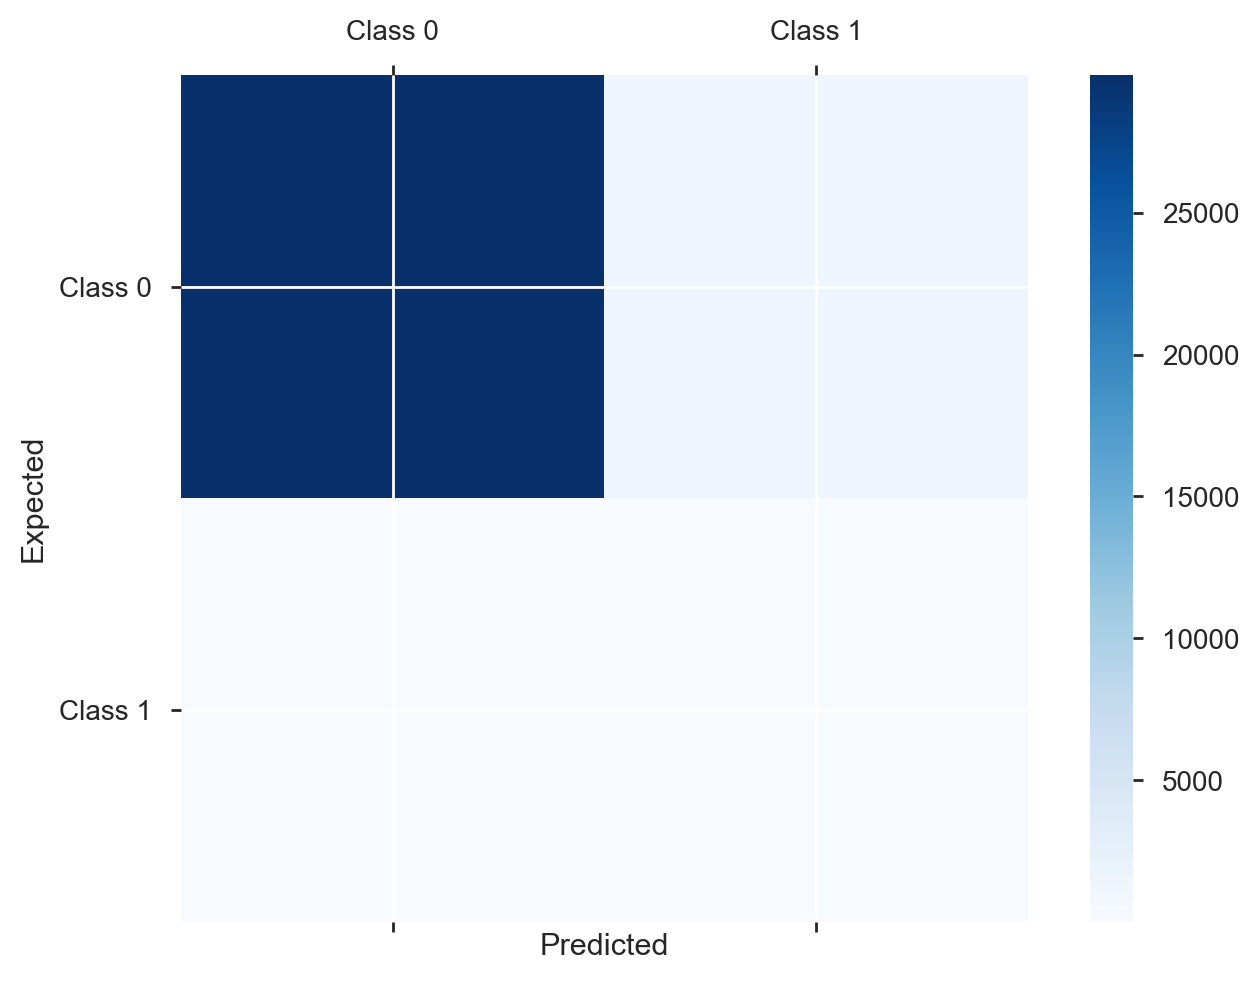

In [229]:
# calibrate model on validation data
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(opt, method='isotonic', cv='prefit')
calibrator.fit(X['train'], y['train'])
# evaluate the model
y_pred = calibrator.predict(X_test[features].as_matrix())
Plot.confusion_matrix(y['test'], y_pred)

### Predicting on oversampled test data

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     31097
           1       0.96      0.90      0.93     31101

   micro avg       0.93      0.93      0.93     62198
   macro avg       0.93      0.93      0.93     62198
weighted avg       0.93      0.93      0.93     62198


Accuracy 0.9292260201292646
Confusion matrix:
 [[29855  1242]
 [ 3160 27941]]


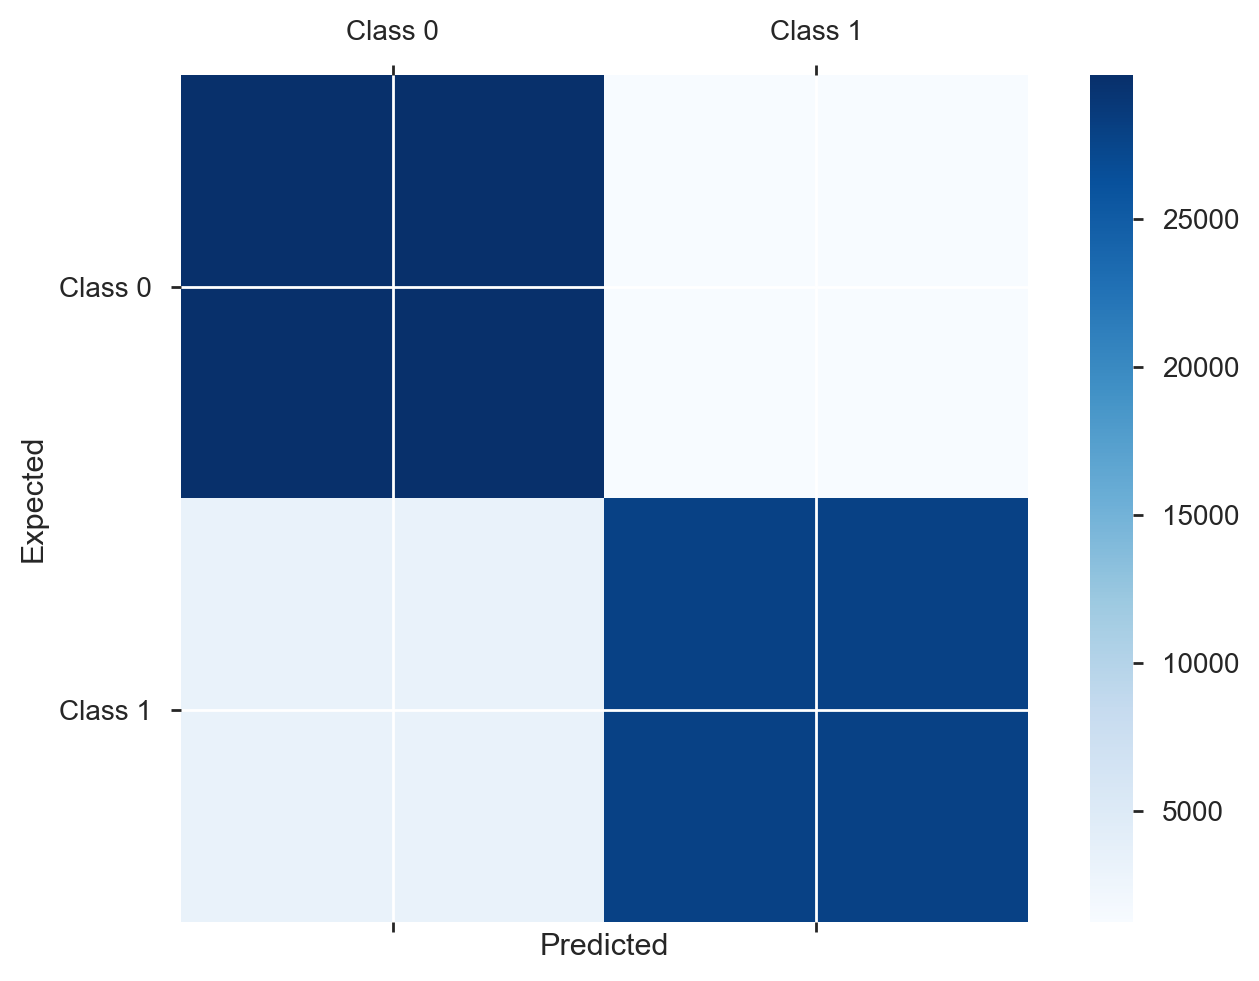

In [239]:
y_pred_test = calibrator.predict(X_test_ADASYN[features].as_matrix())
Plot.confusion_matrix(y_test_ADASYN, y_pred_test)

## XGBoost with SMOTENC Oversampling (All features)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.3 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Finished Training
Best model

Pipeline(memory=None,
     steps=[('clsfr', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.46909356296798244, gamma=7.277257431773251,
       learning_rate=0.008567773934012713, max_delta_step=1, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1472, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4727067692369846))])


Best score on the validation: 0.9985421944029759
*******************Training************************
Best. score: 0.9985421944029759
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93291
           1       1.00      1.00      1.00     93291

   micro avg       1.00      1.00      1.00    186582
   macro avg       1.00      1.00      1.00    186582
weighted avg       1.00   

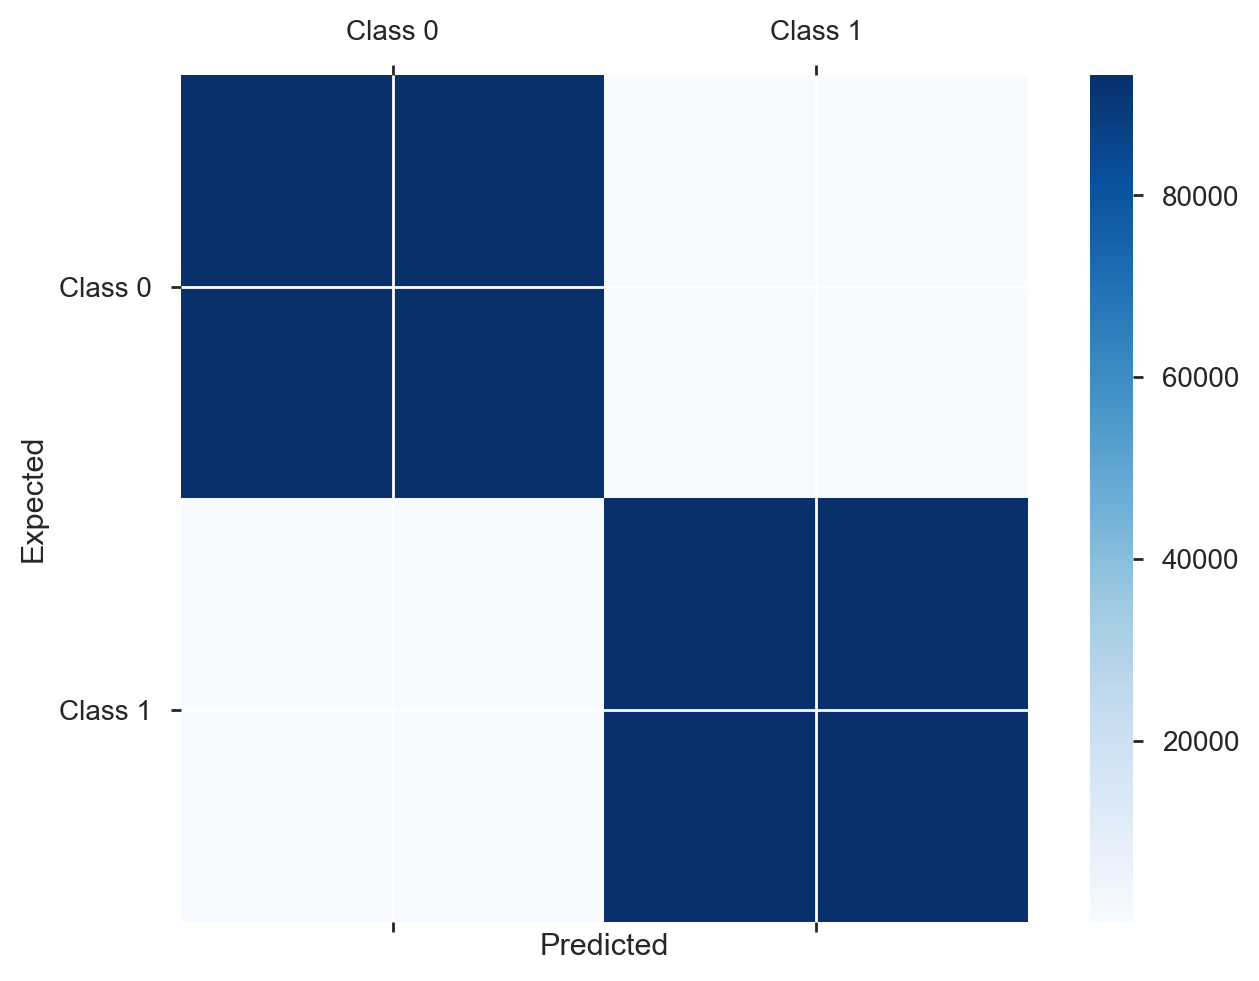

*****************Testing***************************


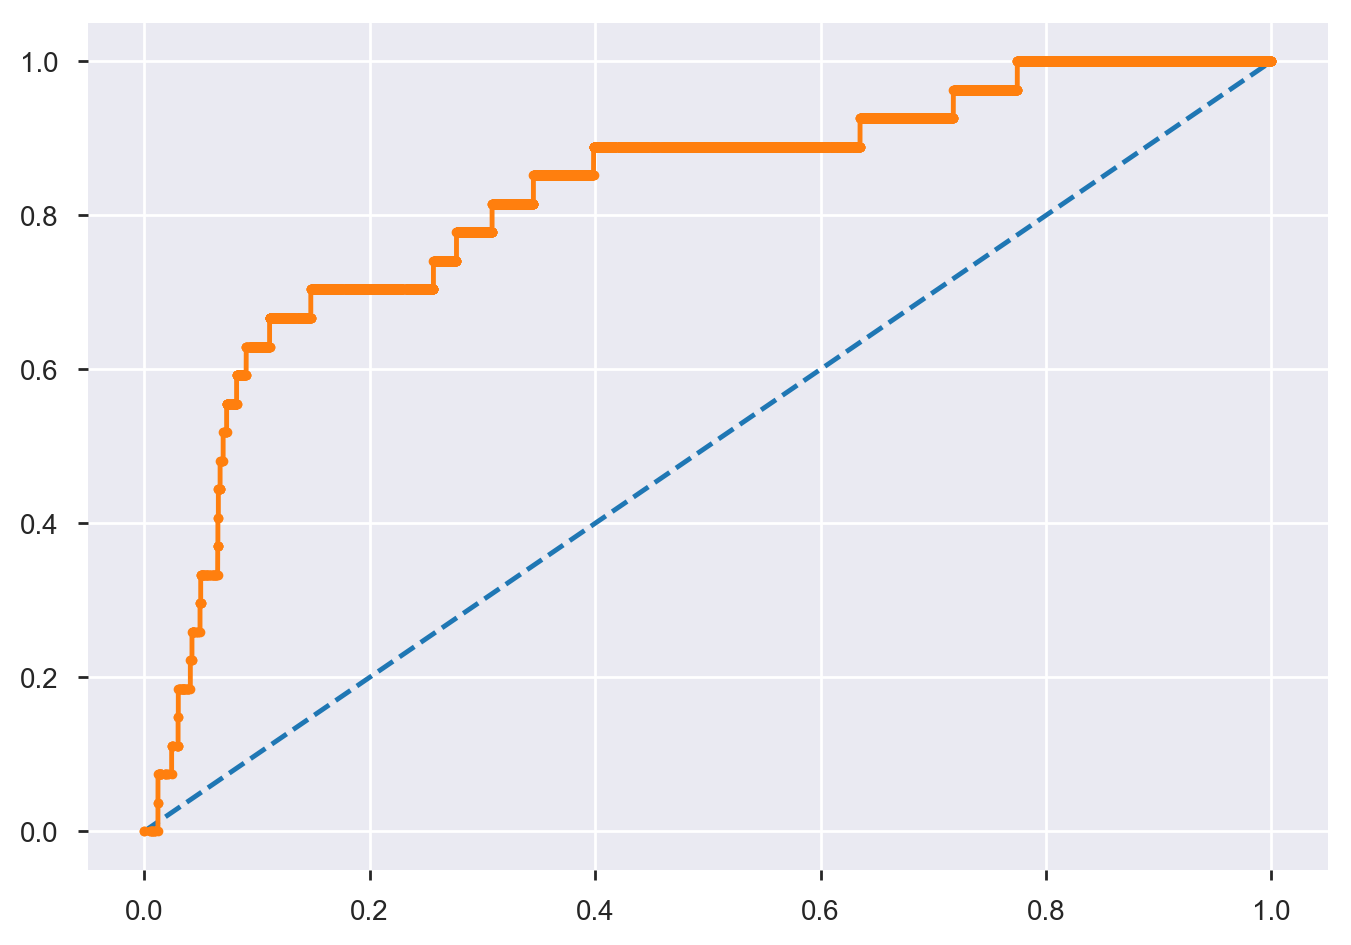

AUC: 0.821
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31097
           1       0.00      0.00      0.00        27

   micro avg       1.00      1.00      1.00     31124
   macro avg       0.50      0.50      0.50     31124
weighted avg       1.00      1.00      1.00     31124


Accuracy 0.9961123248939725
Confusion matrix:
 [[31003    94]
 [   27     0]]


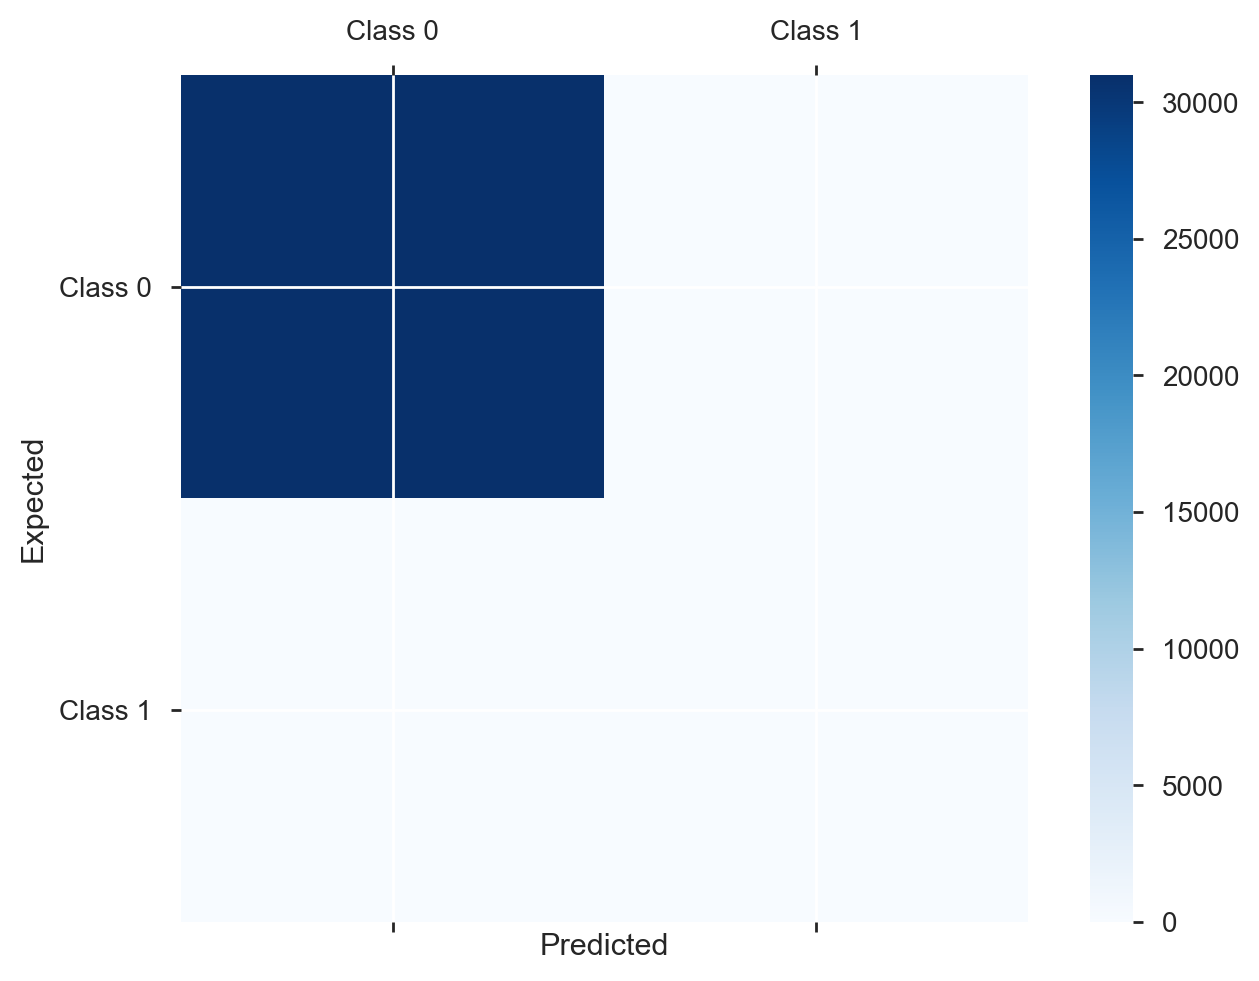

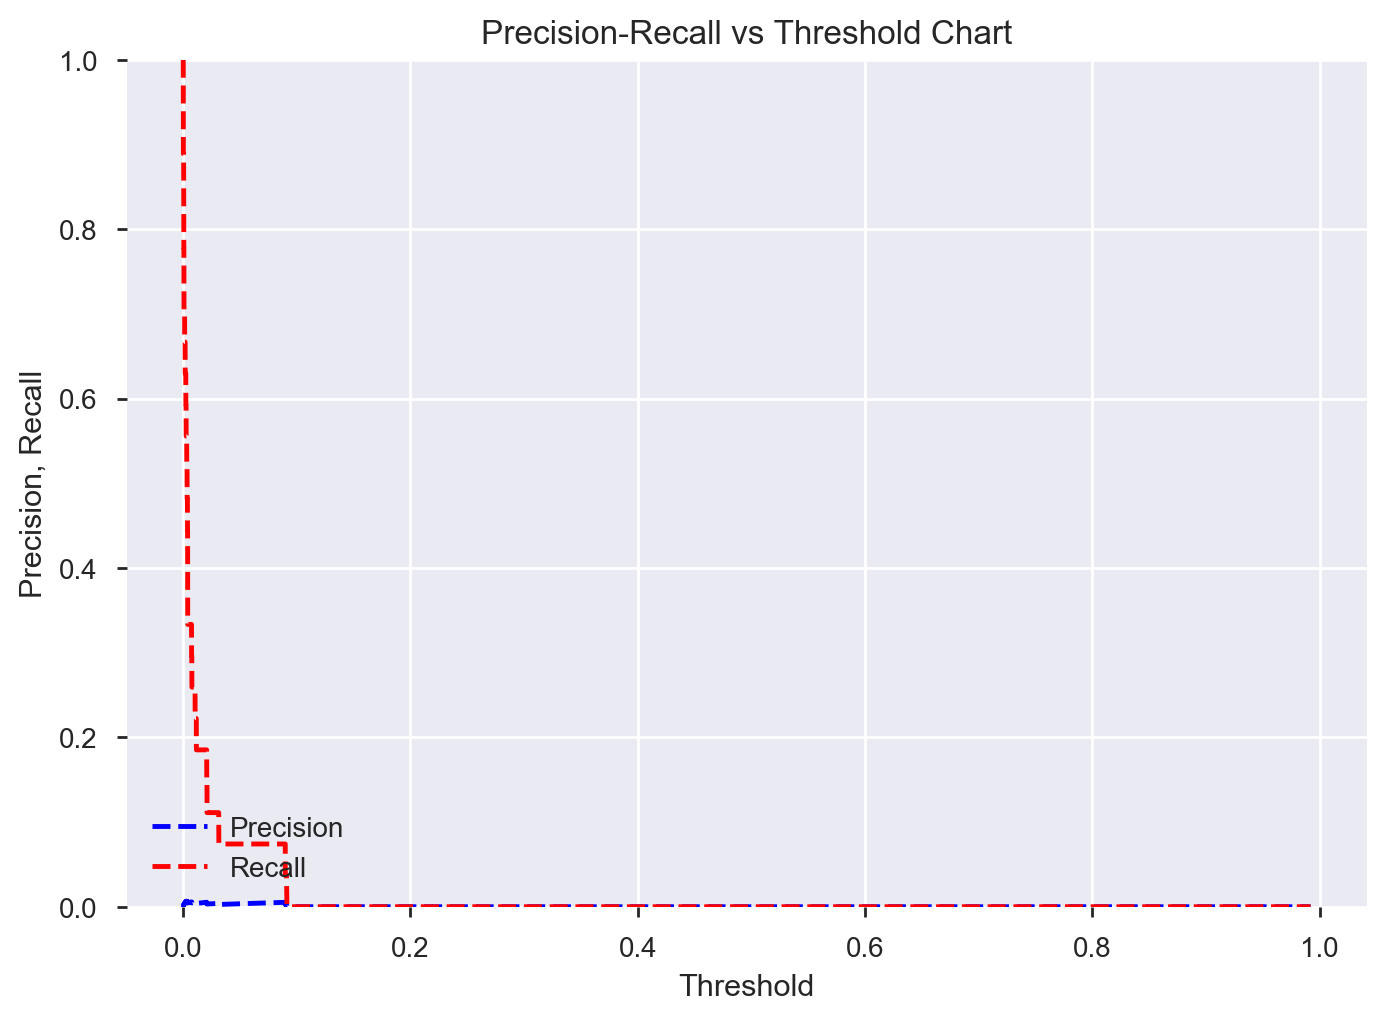

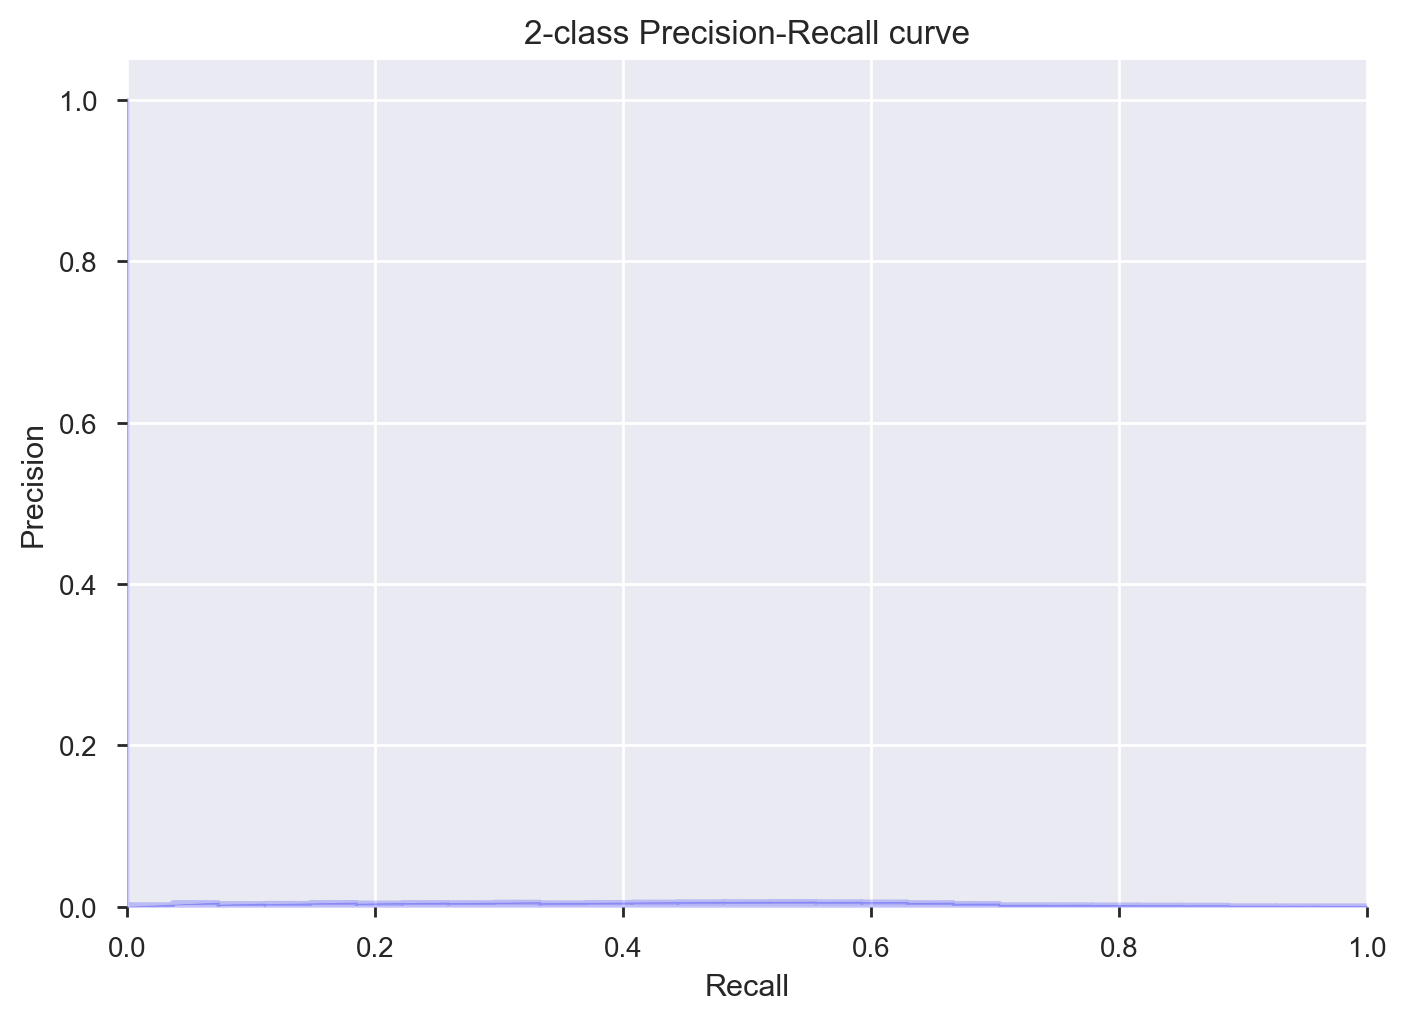

In [242]:
%time
name = 'XGBoost'
features = X_train_sampled_SMOTENC.columns
X = {'train': X_train_sampled_SMOTENC.as_matrix(), 'test':X_test[features].as_matrix()}
y = {'train': y_train_sampled_SMOTENC.as_matrix(), 'test':y_test.as_matrix()}

opt = HyperTuning.baysian_search(name, X['train'], y['train'])
HyperTuning.evaluate_opt(opt, X, y)


## XGBoost with SMOTENC Oversampling (metrics + day of week features)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Finished Training
Best model

Pipeline(memory=None,
     steps=[('clsfr', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.46909356296798244, gamma=7.277257431773251,
       learning_rate=0.008567773934012713, max_delta_step=1, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1472, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4727067692369846))])


Best score on the validation: 0.9941955009467511
*******************Training************************
Best. score: 0.9941955009467511
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     93291
           1       0.99      1.00      0.99     93291

   micro avg       0.99      0.99      0.99    186582
   macro avg       0.99      0.99      0.99    186582
weighted avg       0.99   

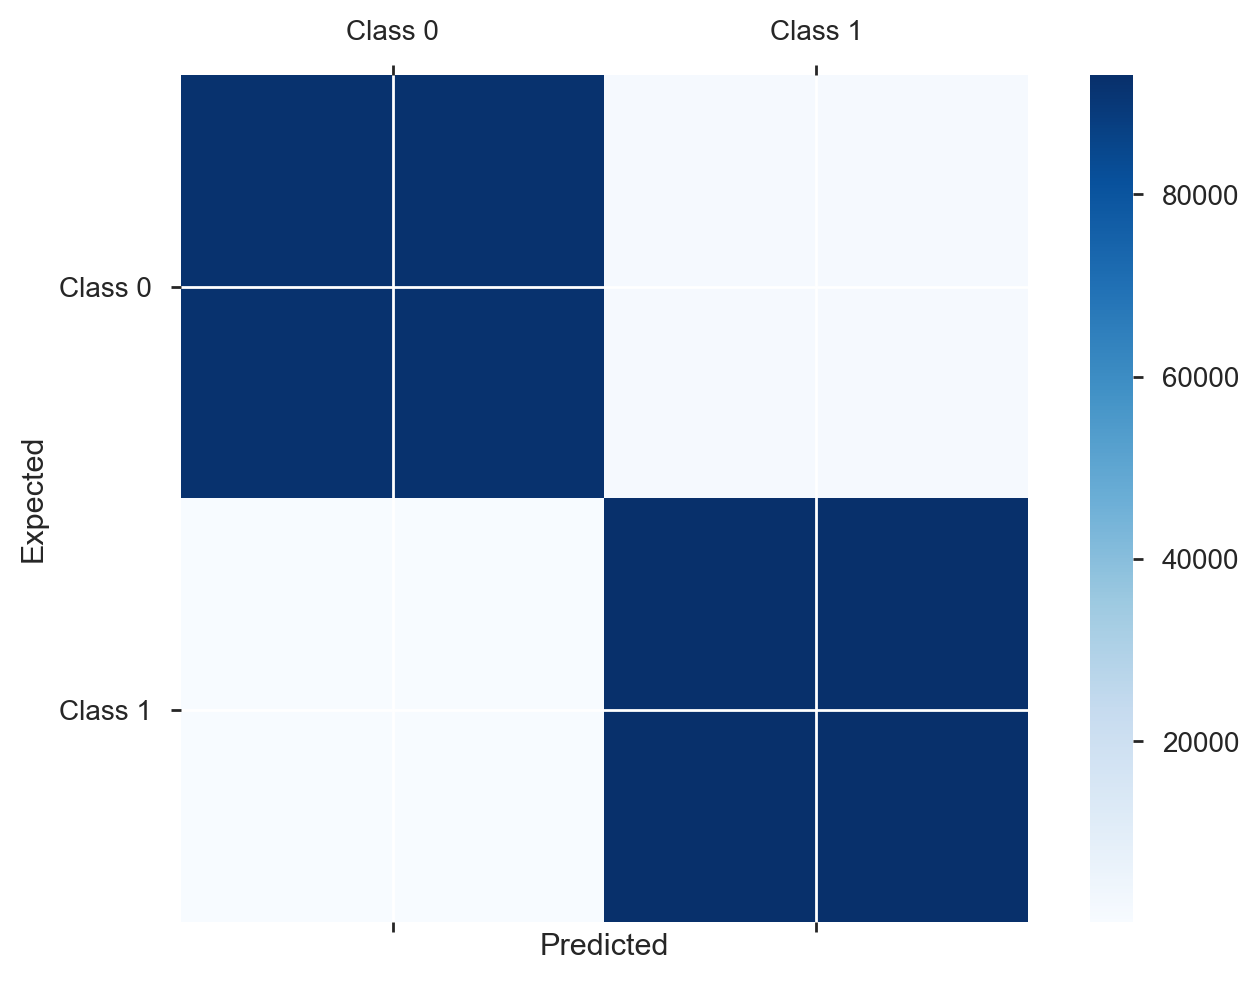

*****************Testing***************************


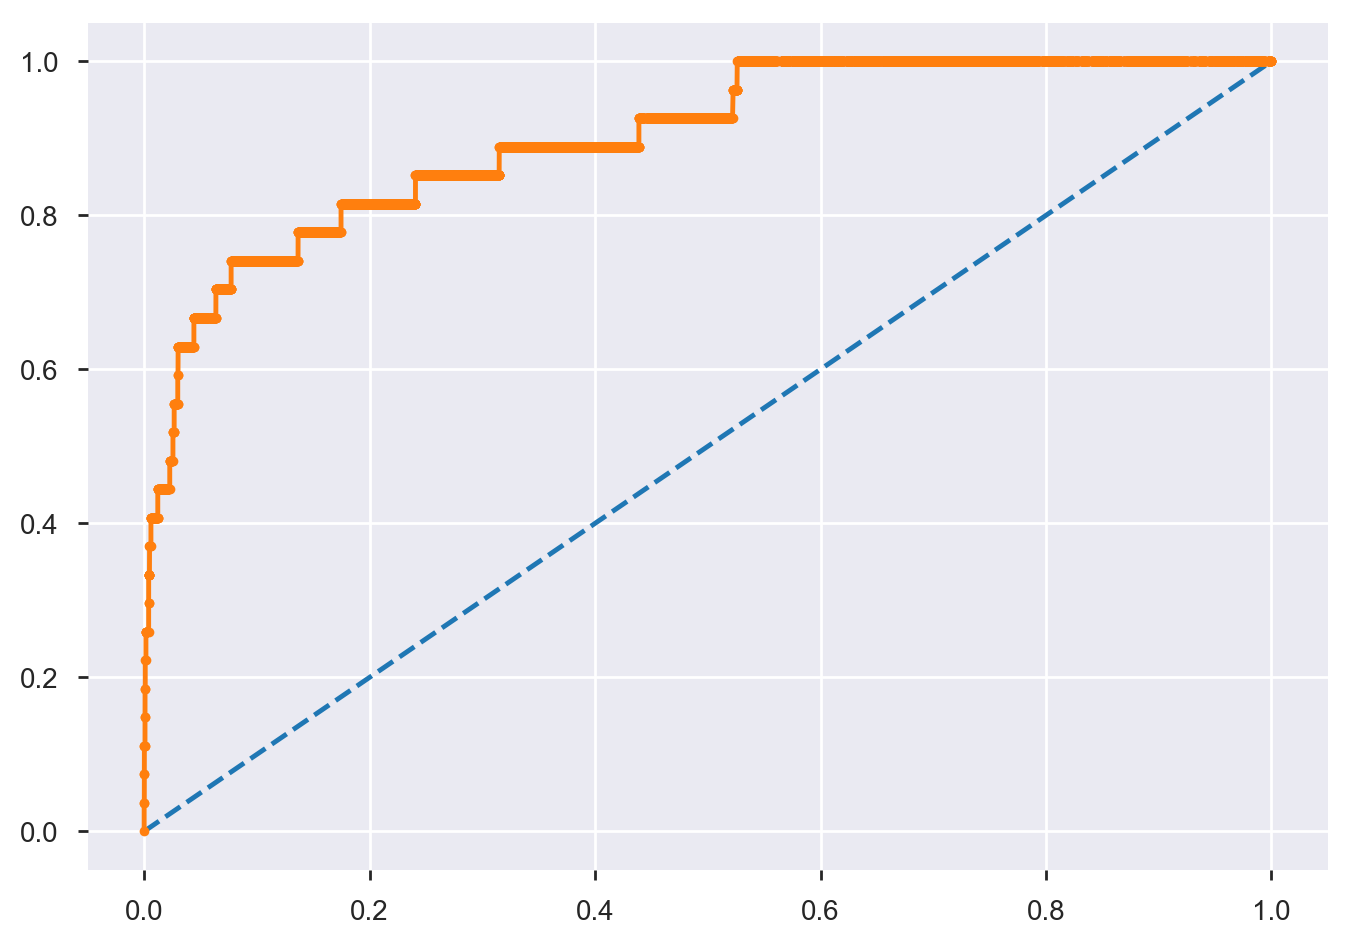

AUC: 0.900
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     31097
           1       0.03      0.41      0.06        27

   micro avg       0.99      0.99      0.99     31124
   macro avg       0.52      0.70      0.53     31124
weighted avg       1.00      0.99      0.99     31124


Accuracy 0.9895257678961573
Confusion matrix:
 [[30787   310]
 [   16    11]]


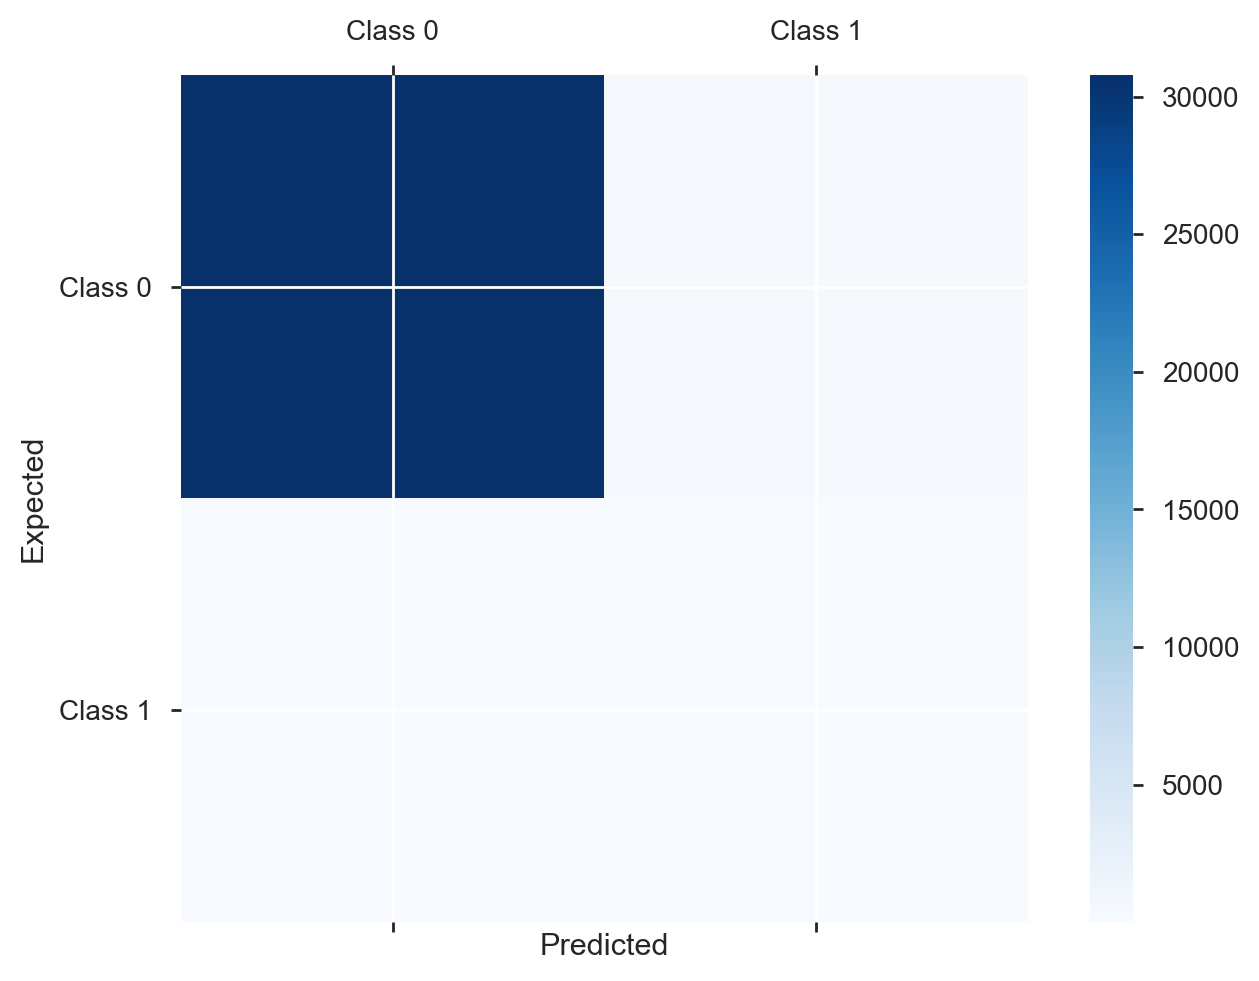

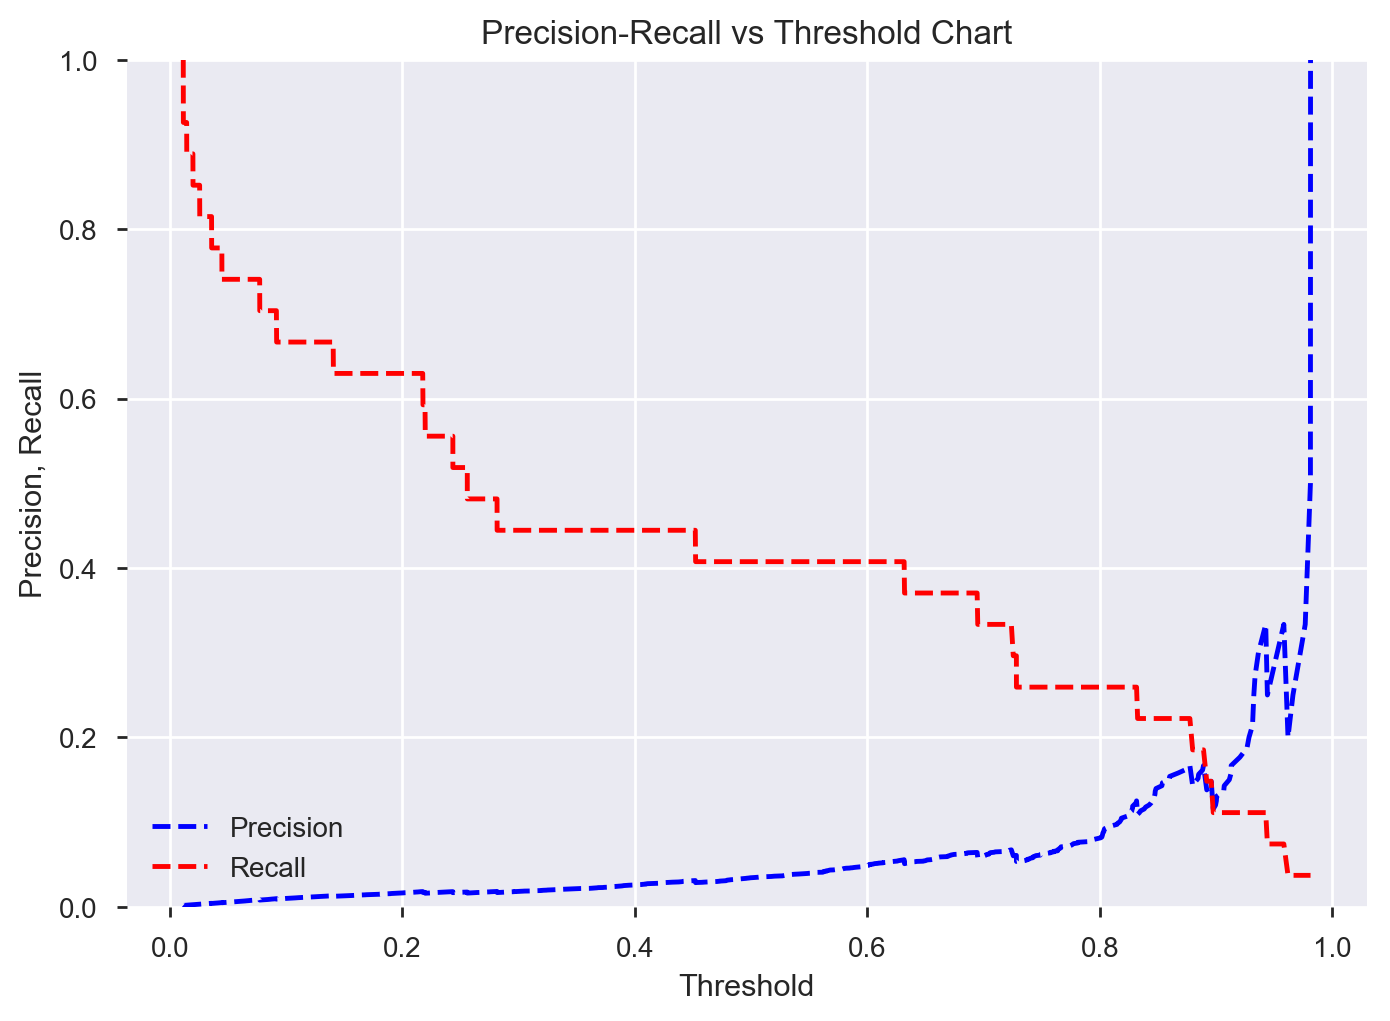

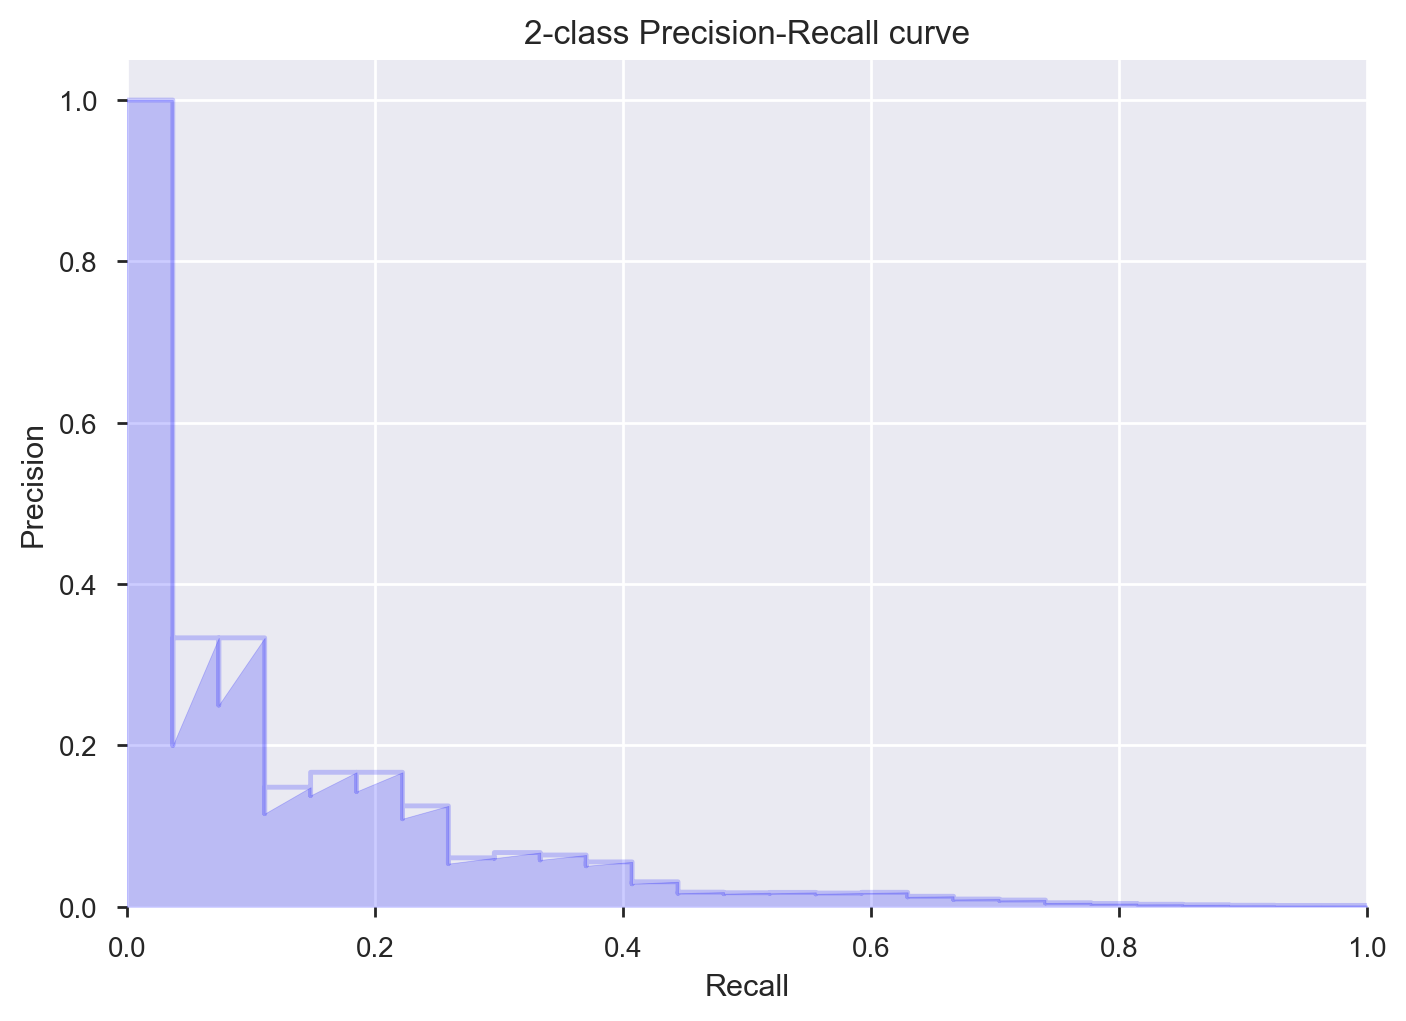

In [252]:
%time
name = 'XGBoost'
features = X_train_sampled_SMOTENC.columns.difference([c for c in X_train_sampled_SMOTENC.columns if 'month' in c])
features = features.difference(['id'])

X = {'train': X_train_sampled_SMOTENC[features].as_matrix(), 'test':X_test[features].as_matrix()}
y = {'train': y_train_sampled_SMOTENC.as_matrix(), 'test':y_test.as_matrix()}

opt = HyperTuning.baysian_search(name, X['train'], y['train'])
HyperTuning.evaluate_opt(opt, X, y)